In [1]:
# Import necessary libraries
import io
import base64
import numpy as np
from dash import Dash, dcc, html, Input, Output, no_update, callback
import plotly.graph_objects as go
from PIL import Image
from sklearn.manifold import TSNE
import torch
from tqdm import tqdm
import random
import umap
from anomaly_detection.training.train import train_model
from anomaly_detection.models.cvae3d import CVAE3D
from anomaly_detection.data.data_loader_V2 import EELSDataset, get_data_loader
from anomaly_detection.config.config_handler import get_config

# Load your configuration
config = get_config('/home/ssulta24/Desktop/VCAE_new/anomaly_detection/config/config.yaml')

# Load your pretrained model V2
model = CVAE3D(config).to("cuda")
model.load_state_dict(torch.load('/home/ssulta24/Desktop/VCAE_new/wandb/run-20241006_160824-x3tu4esv/files/best_model.pth', map_location="cuda")) # best loss 
model.eval()

data = EELSDataset(config)
dataset = data.get_training_sub_images()
dataset = dataset.squeeze(axis=1)
dataset.shape

anom_dataset = data.get_anomaly_sub_images()
anom_dataset = anom_dataset.squeeze(axis=1)
anom_dataset.shape

energy_values = data.get_cropped_energy_values()
print(f"Energy range: {energy_values[0]} to {energy_values[-1]} eV, Length: {len(energy_values)}")

/tmp/ipykernel_452957/4017278462.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/ssulta24/Desktop/VCAE_new/wandb/run-20241006_16

Energy range: 423.30001682043076 to 816.6000324487686 eV, Length: 1312


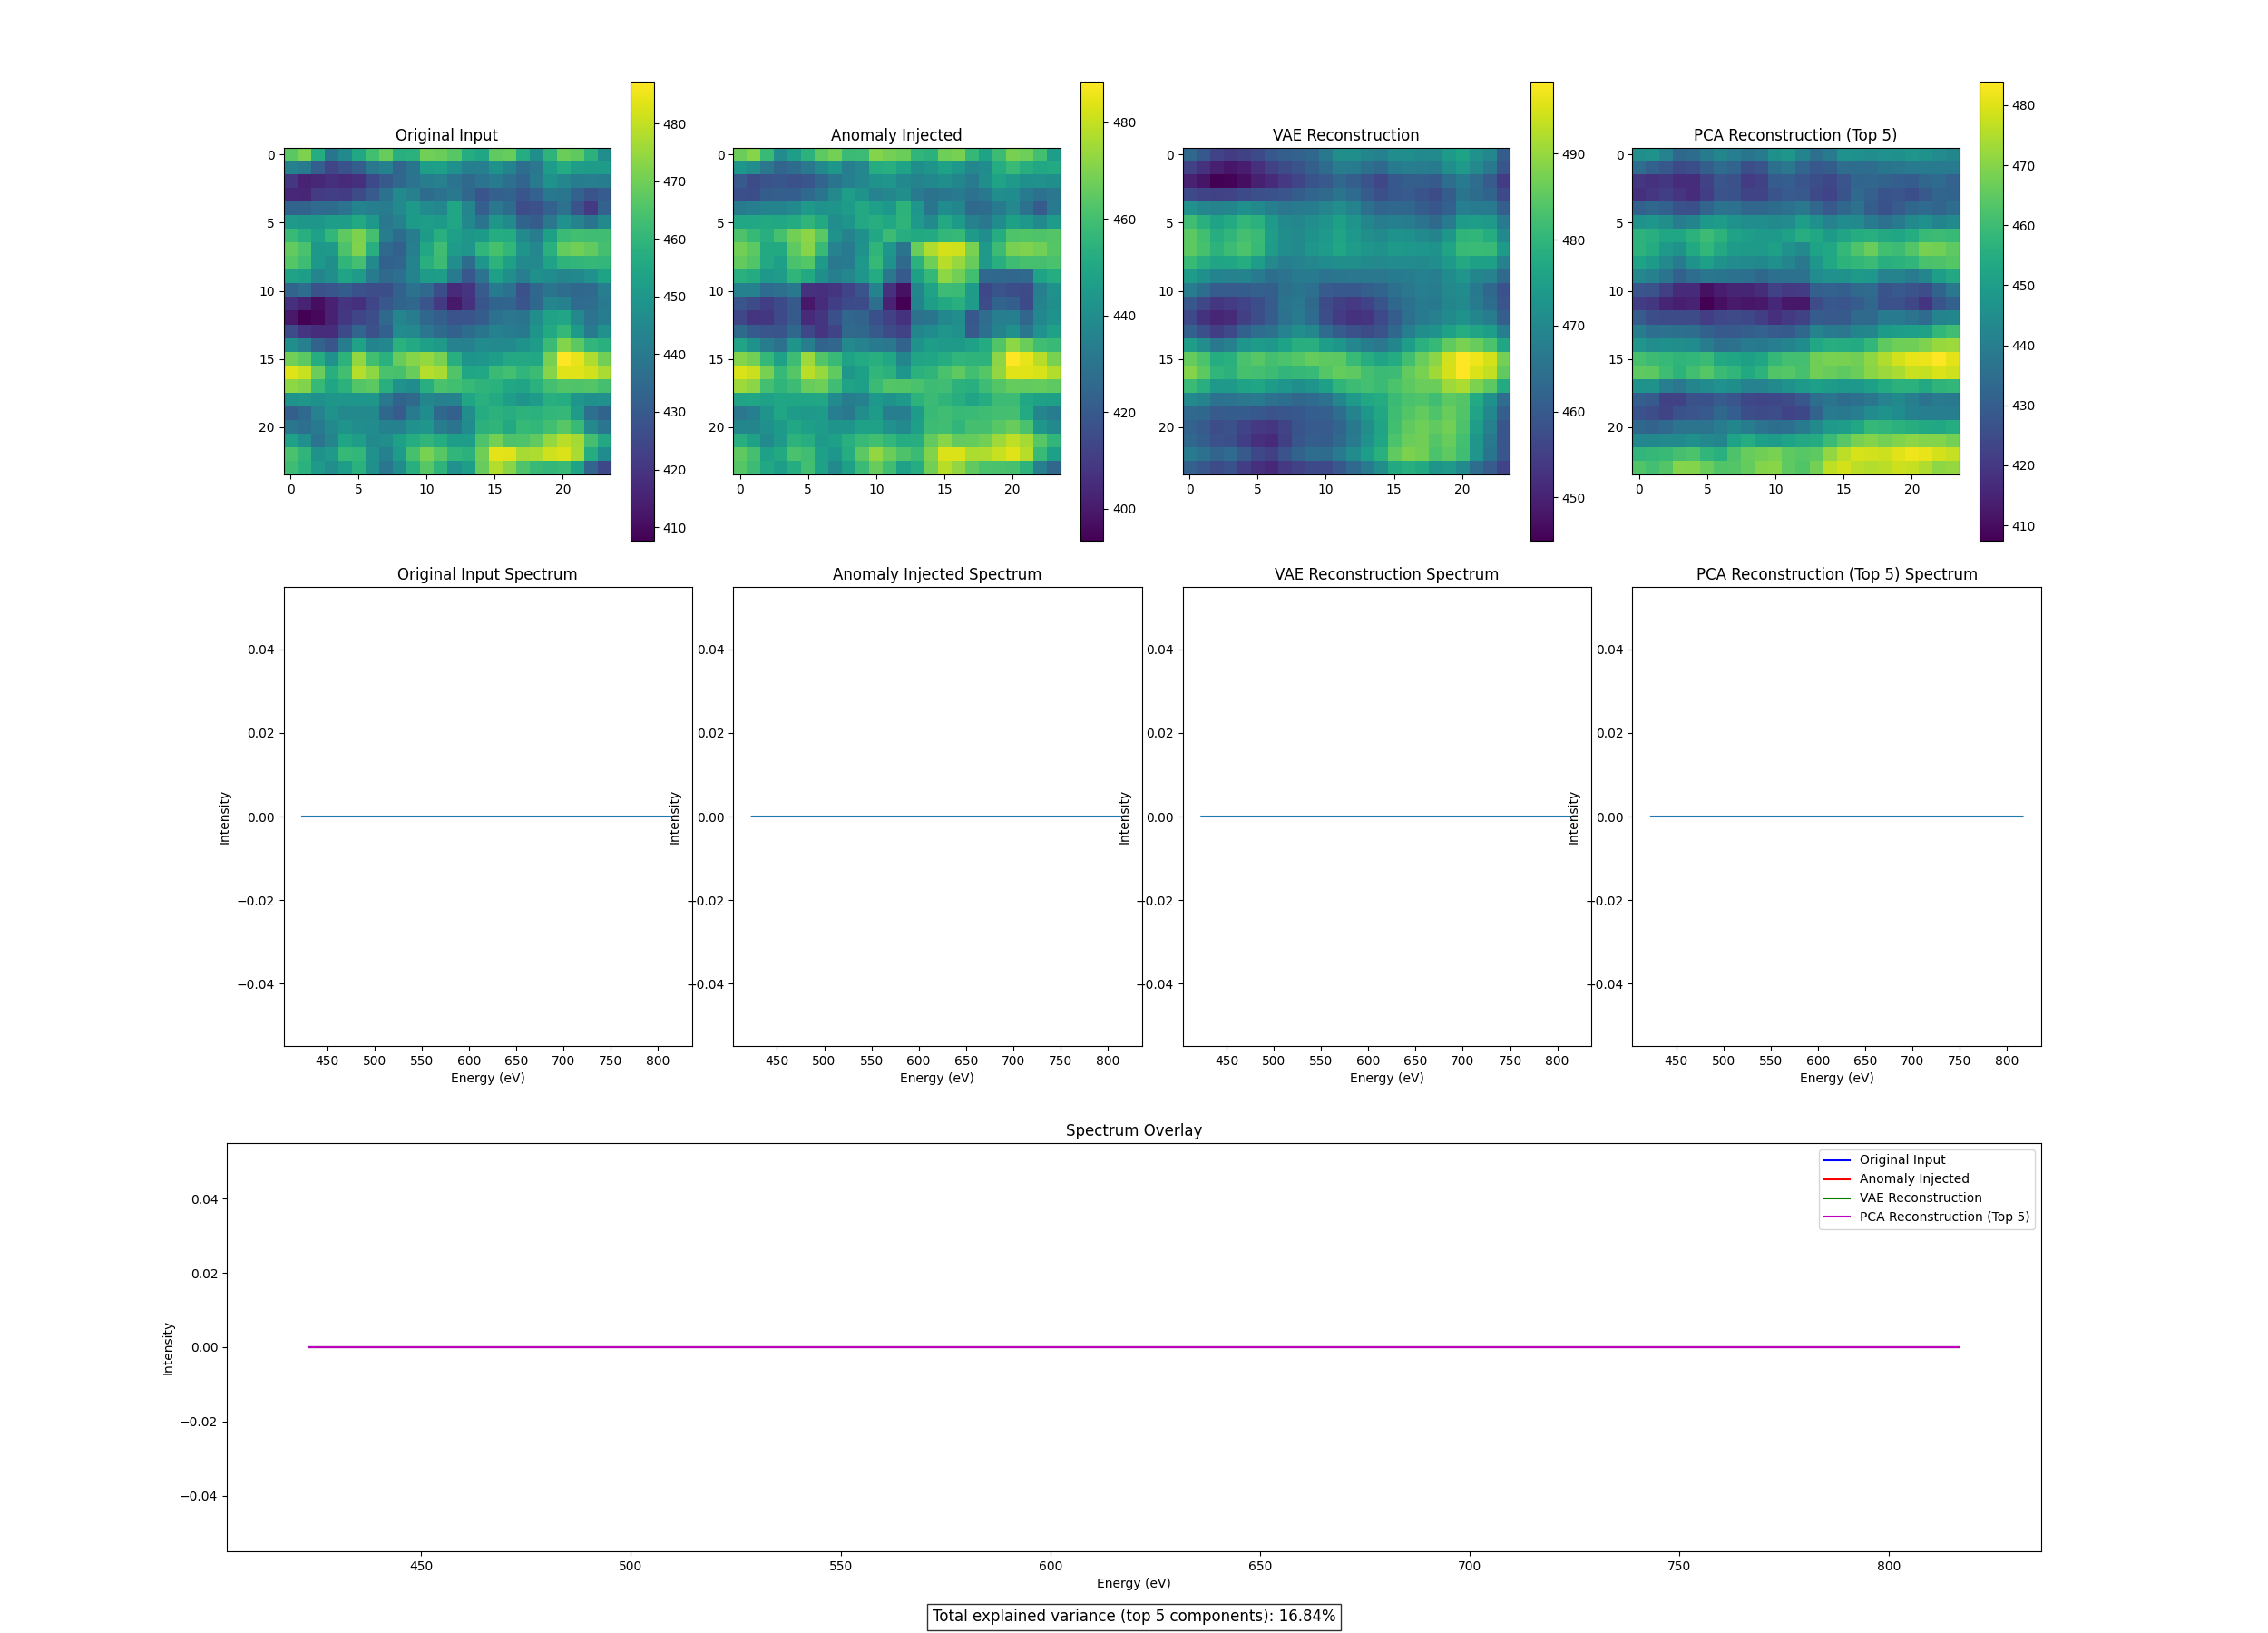

In [3]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch
import numpy as np
from sklearn.decomposition import PCA
%matplotlib widget

def inject_anomalies(image, num_clusters=5, cluster_size=4, shift_amount=45, noise_factor=0.05, peak_reduction_factor=0.1, peak_reduction_probability=0):
    """
    Inject anomalies into the EELS image with added noise and peak reduction options.
    
    Args:
    image (numpy.ndarray): Input image of shape (height, width, energy_channels)
    num_clusters (int): Number of anomalous clusters to inject
    cluster_size (int): Size of each anomalous cluster
    shift_amount (int): Amount to shift the peak (in energy channels)
    noise_factor (float): Factor to control the amount of noise added (0 to 1)
    peak_reduction_factor (float): Factor to reduce peak intensity (0 to 1)
    peak_reduction_probability (float): Probability of applying peak reduction to a cluster (0 to 1)
    
    Returns:
    tuple: (anomalous_image, anomaly_mask)
        anomalous_image (numpy.ndarray): Image with injected anomalies, noise, and peak reductions
        anomaly_mask (numpy.ndarray): Boolean mask indicating anomalous pixels
    """
    anomalous_image = np.copy(image)
    height, width, channels = image.shape
    anomaly_mask = np.zeros((height, width), dtype=bool)
    
    # Add global noise
    noise = np.random.normal(0, noise_factor * np.mean(image), image.shape)
    anomalous_image += noise
    
    for _ in range(num_clusters):
        # Choose a random center for the cluster
        center_y = np.random.randint(cluster_size, height - cluster_size)
        center_x = np.random.randint(cluster_size, width - cluster_size)
        
        # Define the cluster region
        y_start, y_end = center_y - cluster_size // 2, center_y + cluster_size // 2 + 1
        x_start, x_end = center_x - cluster_size // 2, center_x + cluster_size // 2 + 1
        
        # Mark the cluster region as anomalous
        anomaly_mask[y_start:y_end, x_start:x_end] = True
        
        # Shift the peak
        if np.random.random() < 0.5:  # 50% chance to shift left or right
            anomalous_image[y_start:y_end, x_start:x_end, :-shift_amount] = image[y_start:y_end, x_start:x_end, shift_amount:]
        else:
            anomalous_image[y_start:y_end, x_start:x_end, shift_amount:] = image[y_start:y_end, x_start:x_end, :-shift_amount]
        
        # Randomly reduce peak intensity
        if np.random.random() < peak_reduction_probability:
            peak_intensity = np.max(anomalous_image[y_start:y_end, x_start:x_end])
            reduction_amount = peak_intensity * peak_reduction_factor
            anomalous_image[y_start:y_end, x_start:x_end] -= reduction_amount
    
    # Ensure all values are non-negative
    anomalous_image = np.clip(anomalous_image, 0, None)
    
    return anomalous_image, anomaly_mask

def interactive_eels_visualization(model, input_data, device='cuda', sub_image_index=0, n_pca_fit=30, n_pca_reconstruct=5):
    """
    Create an interactive visualization for EELS data comparison, including model prediction and PCA reconstruction
    based on anomaly-injected data, using only the top PCA components.
    """
    model.eval()
    
    # Select the sub-image and inject anomalies
    input_sub_image = input_data[sub_image_index]
    anomalous_sub_image, anomaly_mask = inject_anomalies(input_sub_image)
    
    # Create a modified version of input_data with the anomalous sub-image
    modified_input_data = input_data.copy()
    modified_input_data[sub_image_index] = anomalous_sub_image
    # modified_input_data = np.delete(input_data, sub_image_index, axis=0)
    
    # Generate VAE prediction for anomalous data
    with torch.no_grad():
        anomalous_tensor = torch.tensor(anomalous_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        
        mean, logvar = model.encode(anomalous_tensor)
        z = model.reparameterize(mean, logvar)
        prediction_sub_image = model.decode(z).squeeze().cpu().numpy()
    
    # Perform PCA
    pca = PCA(n_components=n_pca_fit)
    flattened_data = modified_input_data.reshape(modified_input_data.shape[0], -1)
    pca_result = pca.fit_transform(flattened_data)
    
    # Reconstruct using only the top n_pca_reconstruct components
    top_components = pca_result[:, :n_pca_reconstruct]
    reduced_components = pca.components_[:n_pca_reconstruct, :]
    pca_reconstruction = np.dot(top_components, reduced_components) + pca.mean_
    pca_reconstruction = pca_reconstruction.reshape(modified_input_data.shape)
    pca_sub_image = pca_reconstruction[sub_image_index]
    
    # Calculate explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    total_explained_variance = np.sum(explained_variance_ratio[:n_pca_reconstruct])
    
    # # Create energy array
    # energy_values = np.linspace(energy_range[0], energy_range[1], input_sub_image.shape[2])
    
    # Create the main figure
    fig, axs = plt.subplots(3, 4, figsize=(25, 18), gridspec_kw={'height_ratios': [1, 1, 1]})
    plt.subplots_adjust(bottom=0.05, top=0.95, hspace=0.1, wspace=0.1)
    
    # Plot images
    images = [input_sub_image, anomalous_sub_image, prediction_sub_image, pca_sub_image]
    titles = ['Original Input', 'Anomaly Injected', 'VAE Reconstruction', f'PCA Reconstruction (Top {n_pca_reconstruct})']
    for i, (img, title) in enumerate(zip(images, titles)):
        im = axs[0, i].imshow(np.sum(img, axis=2), cmap='viridis')
        axs[0, i].set_title(title)
        plt.colorbar(im, ax=axs[0, i])
    
    # Create empty line plots for spectra
    spectra = []
    for i, title in enumerate(titles):
        spec, = axs[1, i].plot(energy_values, np.zeros_like(energy_values))
        axs[1, i].set_title(f'{title} Spectrum')
        axs[1, i].set_xlabel('Energy (eV)')
        axs[1, i].set_ylabel('Intensity')
        spectra.append(spec)
    
    # Create overlay plot
    overlay_specs = []
    colors = ['b', 'r', 'g', 'm']
    for color, title in zip(colors, titles):
        spec, = axs[2, 0].plot(energy_values, np.zeros_like(energy_values), color=color, label=title)
        overlay_specs.append(spec)
    axs[2, 0].set_title('Spectrum Overlay')
    axs[2, 0].set_xlabel('Energy (eV)')
    axs[2, 0].set_ylabel('Intensity')
    axs[2, 0].legend()
    
    # Remove unused subplots
    for ax in axs[2, 1:]:
        fig.delaxes(ax)
    
    # Adjust overlay plot to span full width
    axs[2, 0].set_position([0.1, 0.05, 0.8, 0.25])
    
    # Add text to show explained variance
    fig.text(0.5, 0.01, f'Total explained variance (top {n_pca_reconstruct} components): {total_explained_variance:.2%}', 
             ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    # Function to update spectra on mouse hover
    def update_spectra(event):
        for ax in axs[0]:
            if event.inaxes == ax:
                x, y = int(event.xdata), int(event.ydata)
                if 0 <= x < input_sub_image.shape[1] and 0 <= y < input_sub_image.shape[0]:
                    pixel_spectra = [img[y, x, :] for img in images]
                    
                    # Calculate min and max for this pixel across all spectra
                    pixel_min = min(spec.min() for spec in pixel_spectra)
                    pixel_max = max(spec.max() for spec in pixel_spectra)
                    
                    for spec, pixel_spectrum in zip(spectra, pixel_spectra):
                        spec.set_ydata(pixel_spectrum)
                    
                    # Add small offsets to separate overlapping lines
                    offsets = np.linspace(0, (pixel_max - pixel_min) * 0.1, len(overlay_specs))
                    for overlay_spec, pixel_spectrum, offset in zip(overlay_specs, pixel_spectra, offsets):
                        overlay_spec.set_ydata(pixel_spectrum + offset)
                    
                    for ax in axs[1]:
                        ax.relim()
                        ax.autoscale_view()
                    
                    # Set y-axis limits for overlay plot based on this pixel's spectra
                    axs[2, 0].set_ylim(pixel_min, pixel_max * 1.1)  # Add 10% to the top for offsets
                    axs[2, 0].relim()
                    axs[2, 0].autoscale_view()
                    
                    # Add text to show current pixel coordinates
                    axs[2, 0].set_title(f'Spectrum Overlay (Pixel: {x}, {y})')
                    
                    fig.canvas.draw_idle()
                break
    
    fig.canvas.mpl_connect('motion_notify_event', update_spectra)
    
    plt.show()
    
    return pca, modified_input_data, anomaly_mask

# Usage
pca, modified_anomalous_data, anomaly_mask = interactive_eels_visualization(model, dataset, device="cuda", sub_image_index=19, n_pca_fit=30, n_pca_reconstruct=5)

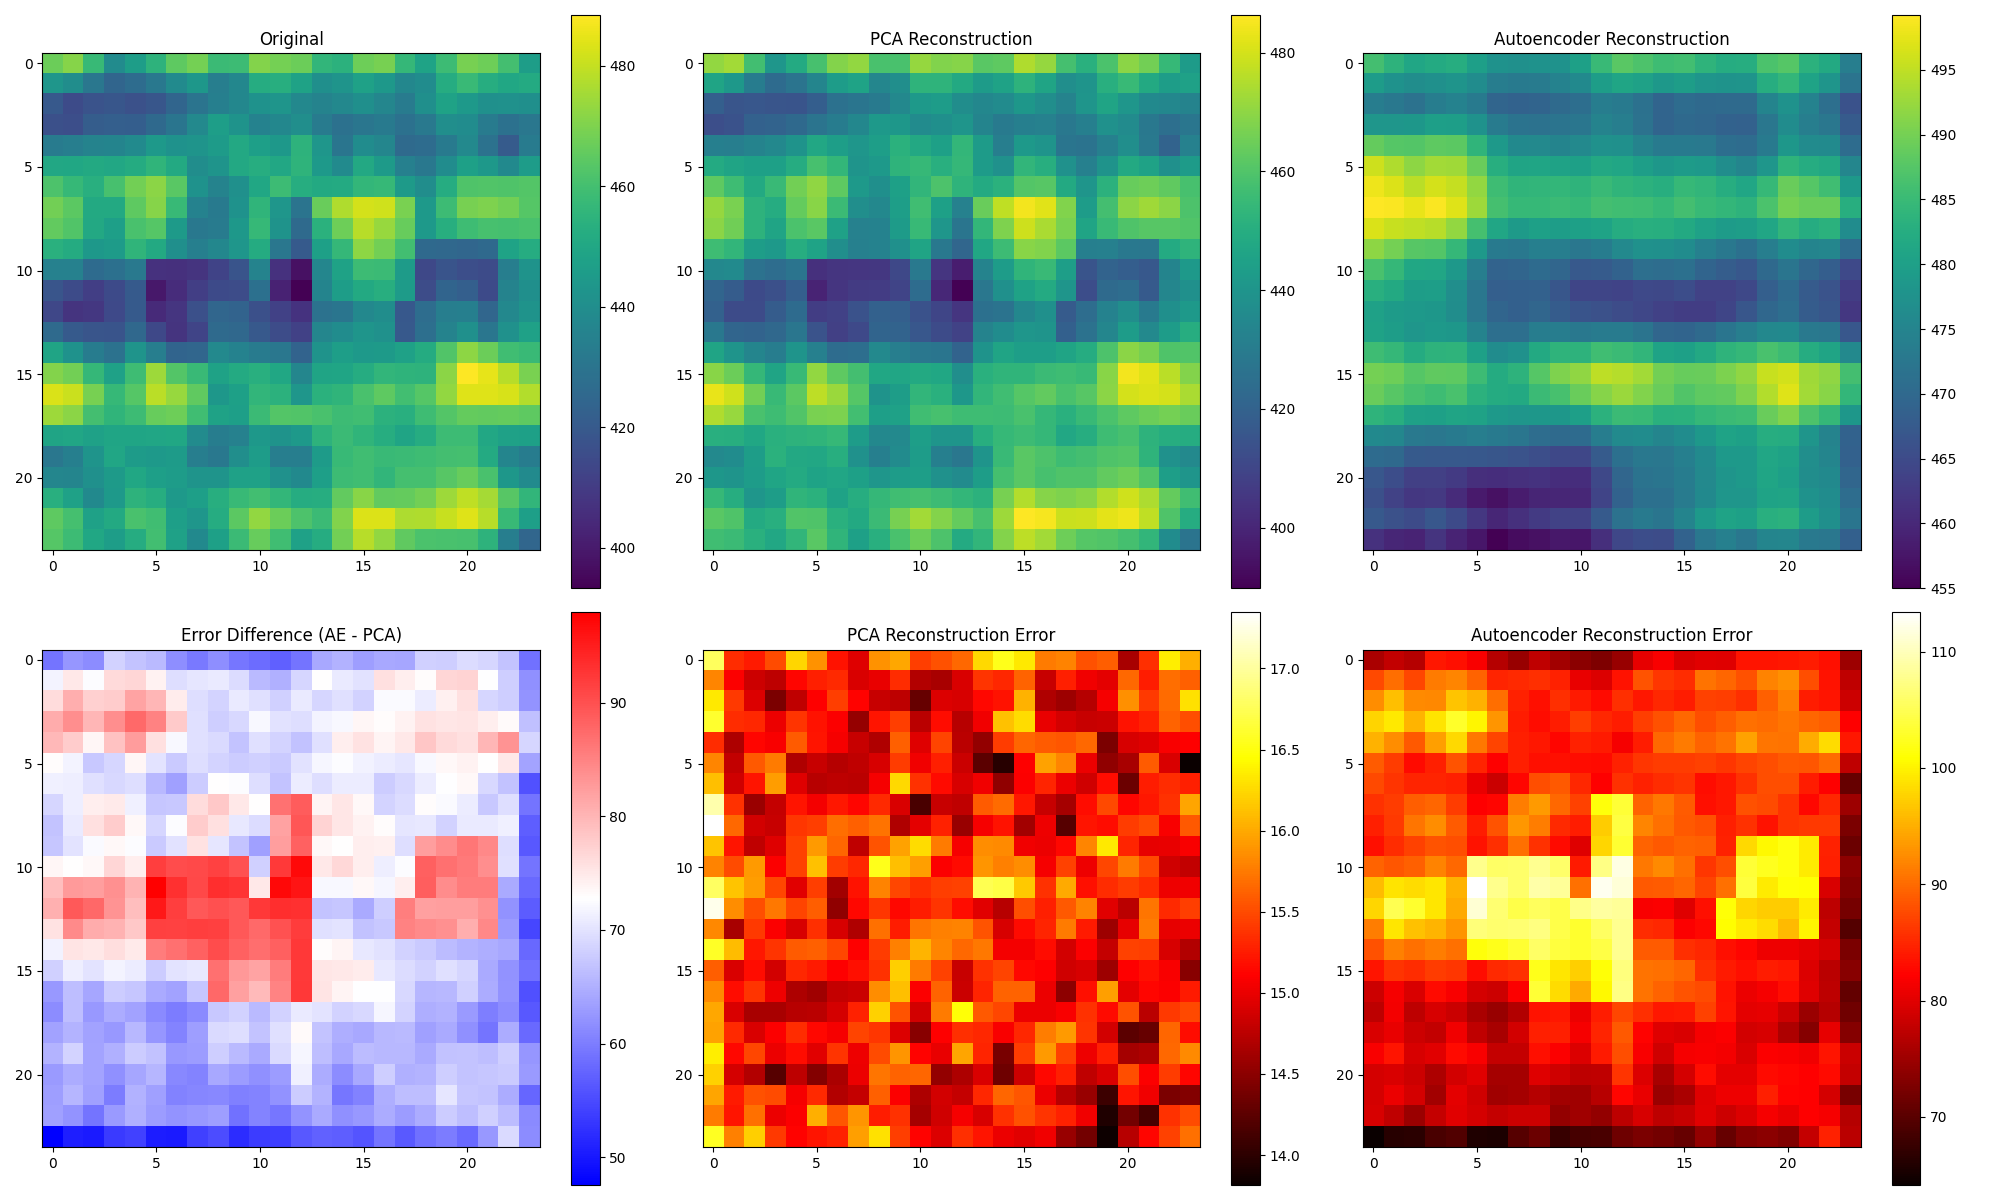

PCA Mean Error: 15.2702
Autoencoder Mean Error: 86.2033
Max PCA Error: 17.3500
Max Autoencoder Error: 113.4375


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

def compare_reconstruction_errors(model, input_data, pca, sub_image_index, device='cuda'):
    """
    Compare reconstruction errors between PCA and Autoencoder.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    pca (sklearn.decomposition.PCA): Fitted PCA object
    sub_image_index (int): Index of the sub-image to visualize
    device (str): The device to run the model on ('cuda' or 'cpu')
    
    Returns:
    None (displays the plot)
    """
    # Select the sub-image
    input_sub_image = input_data[sub_image_index]
    
    # PCA reconstruction
    flattened_sub_image = input_sub_image.reshape(1, -1)
    pca_reconstruction = pca.inverse_transform(pca.transform(flattened_sub_image))
    pca_reconstruction = pca_reconstruction.reshape(input_sub_image.shape)
    
    # Autoencoder reconstruction
    with torch.no_grad():
        input_tensor = torch.tensor(input_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        reconstructed, _, _ = model(input_tensor)
        ae_reconstruction = reconstructed.squeeze().cpu().numpy()
    
    # Calculate reconstruction errors
    pca_error = np.abs(input_sub_image - pca_reconstruction)
    ae_error = np.abs(input_sub_image - ae_reconstruction)
    
    # Calculate error maps (sum along energy axis)
    pca_error_map = np.sum(pca_error, axis=-1)
    ae_error_map = np.sum(ae_error, axis=-1)
    
    # Plotting
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Original image
    im_orig = axs[0, 0].imshow(np.sum(input_sub_image, axis=-1), cmap='viridis')
    axs[0, 0].set_title("Original")
    plt.colorbar(im_orig, ax=axs[0, 0])
    
    # PCA reconstruction
    im_pca = axs[0, 1].imshow(np.sum(pca_reconstruction, axis=-1), cmap='viridis')
    axs[0, 1].set_title("PCA Reconstruction")
    plt.colorbar(im_pca, ax=axs[0, 1])
    
    # Autoencoder reconstruction
    im_ae = axs[0, 2].imshow(np.sum(ae_reconstruction, axis=-1), cmap='viridis')
    axs[0, 2].set_title("Autoencoder Reconstruction")
    plt.colorbar(im_ae, ax=axs[0, 2])
    
    # PCA error map
    im_pca_err = axs[1, 1].imshow(pca_error_map, cmap='hot')
    axs[1, 1].set_title("PCA Reconstruction Error")
    plt.colorbar(im_pca_err, ax=axs[1, 1])
    
    # Autoencoder error map
    im_ae_err = axs[1, 2].imshow(ae_error_map, cmap='hot')
    axs[1, 2].set_title("Autoencoder Reconstruction Error")
    plt.colorbar(im_ae_err, ax=axs[1, 2])
    
    # Error difference (AE - PCA)
    error_diff = ae_error_map - pca_error_map
    im_diff = axs[1, 0].imshow(error_diff, cmap='bwr')
    axs[1, 0].set_title("Error Difference (AE - PCA)")
    plt.colorbar(im_diff, ax=axs[1, 0])
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"PCA Mean Error: {np.mean(pca_error_map):.4f}")
    print(f"Autoencoder Mean Error: {np.mean(ae_error_map):.4f}")
    print(f"Max PCA Error: {np.max(pca_error_map):.4f}")
    print(f"Max Autoencoder Error: {np.max(ae_error_map):.4f}")

# Usage example:
compare_reconstruction_errors(model, modified_anomalous_data, pca, sub_image_index=19, device="cuda")

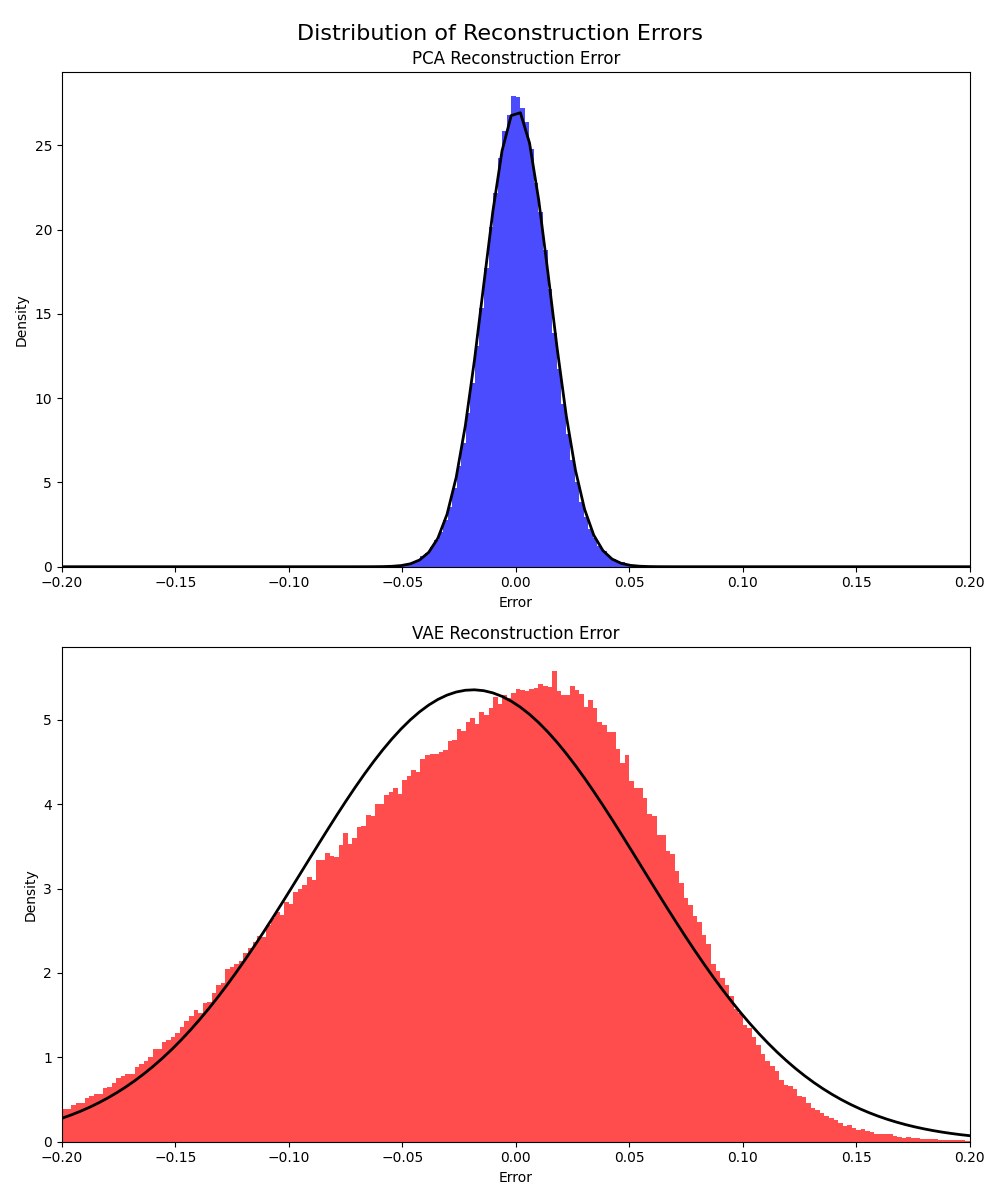

PCA Mean Error: 0.000332
VAE Mean Error: -0.018841
PCA Std Dev: 0.014716
VAE Std Dev: 0.074478
PCA Median Error: 0.000345
VAE Median Error: -0.012300


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import norm

def generate_error_distribution_histograms(model, input_data, pca, sub_image_index, device='cuda', bins=100):
    """
    Generate separate histograms of error distributions for VAE and PCA reconstructions.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    pca (sklearn.decomposition.PCA): Fitted PCA object
    sub_image_index (int): Index of the sub-image to visualize
    device (str): The device to run the model on ('cuda' or 'cpu')
    bins (int): Number of bins for the histogram
    
    Returns:
    None (displays the plots)
    """
    # Select the sub-image
    input_sub_image = input_data[sub_image_index]

    # PCA reconstruction
    flattened_sub_image = input_sub_image.reshape(1, -1)
    pca_reconstruction = pca.inverse_transform(pca.transform(flattened_sub_image))
    pca_reconstruction = pca_reconstruction.reshape(input_sub_image.shape)

    # VAE reconstruction
    with torch.no_grad():
        input_tensor = torch.tensor(input_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        reconstructed, _, _ = model(input_tensor)
        vae_reconstruction = reconstructed.squeeze().cpu().numpy()

    # Calculate errors (not squared)
    pca_error = input_sub_image - pca_reconstruction
    vae_error = input_sub_image - vae_reconstruction

    # Flatten the error arrays
    pca_error_flat = pca_error.flatten()
    vae_error_flat = vae_error.flatten()

    # Create histograms
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    fig.suptitle('Distribution of Reconstruction Errors', fontsize=16)

    # PCA Histogram
    ax1.hist(pca_error_flat, bins=bins, range=(-0.2, 0.2), density=True, alpha=0.7, color='blue')
    ax1.set_title('PCA Reconstruction Error')
    ax1.set_xlabel('Error')
    ax1.set_ylabel('Density')
    ax1.set_xlim(-0.2, 0.2)

    # Fit normal distribution to PCA errors
    mu_pca, std_pca = norm.fit(pca_error_flat)
    xmin, xmax = ax1.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_pca, std_pca)
    ax1.plot(x, p, 'k', linewidth=2)

    # VAE Histogram
    ax2.hist(vae_error_flat, bins=bins, range=(-0.2, 0.2), density=True, alpha=0.7, color='red')
    ax2.set_title('VAE Reconstruction Error')
    ax2.set_xlabel('Error')
    ax2.set_ylabel('Density')
    ax2.set_xlim(-0.2, 0.2)

    # Fit normal distribution to VAE errors
    mu_vae, std_vae = norm.fit(vae_error_flat)
    xmin, xmax = ax2.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_vae, std_vae)
    ax2.plot(x, p, 'k', linewidth=2)

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"PCA Mean Error: {np.mean(pca_error_flat):.6f}")
    print(f"VAE Mean Error: {np.mean(vae_error_flat):.6f}")
    print(f"PCA Std Dev: {np.std(pca_error_flat):.6f}")
    print(f"VAE Std Dev: {np.std(vae_error_flat):.6f}")
    print(f"PCA Median Error: {np.median(pca_error_flat):.6f}")
    print(f"VAE Median Error: {np.median(vae_error_flat):.6f}")

# Usage example:
generate_error_distribution_histograms(model, modified_anomalous_data, pca, sub_image_index=19, device="cuda", bins=200)

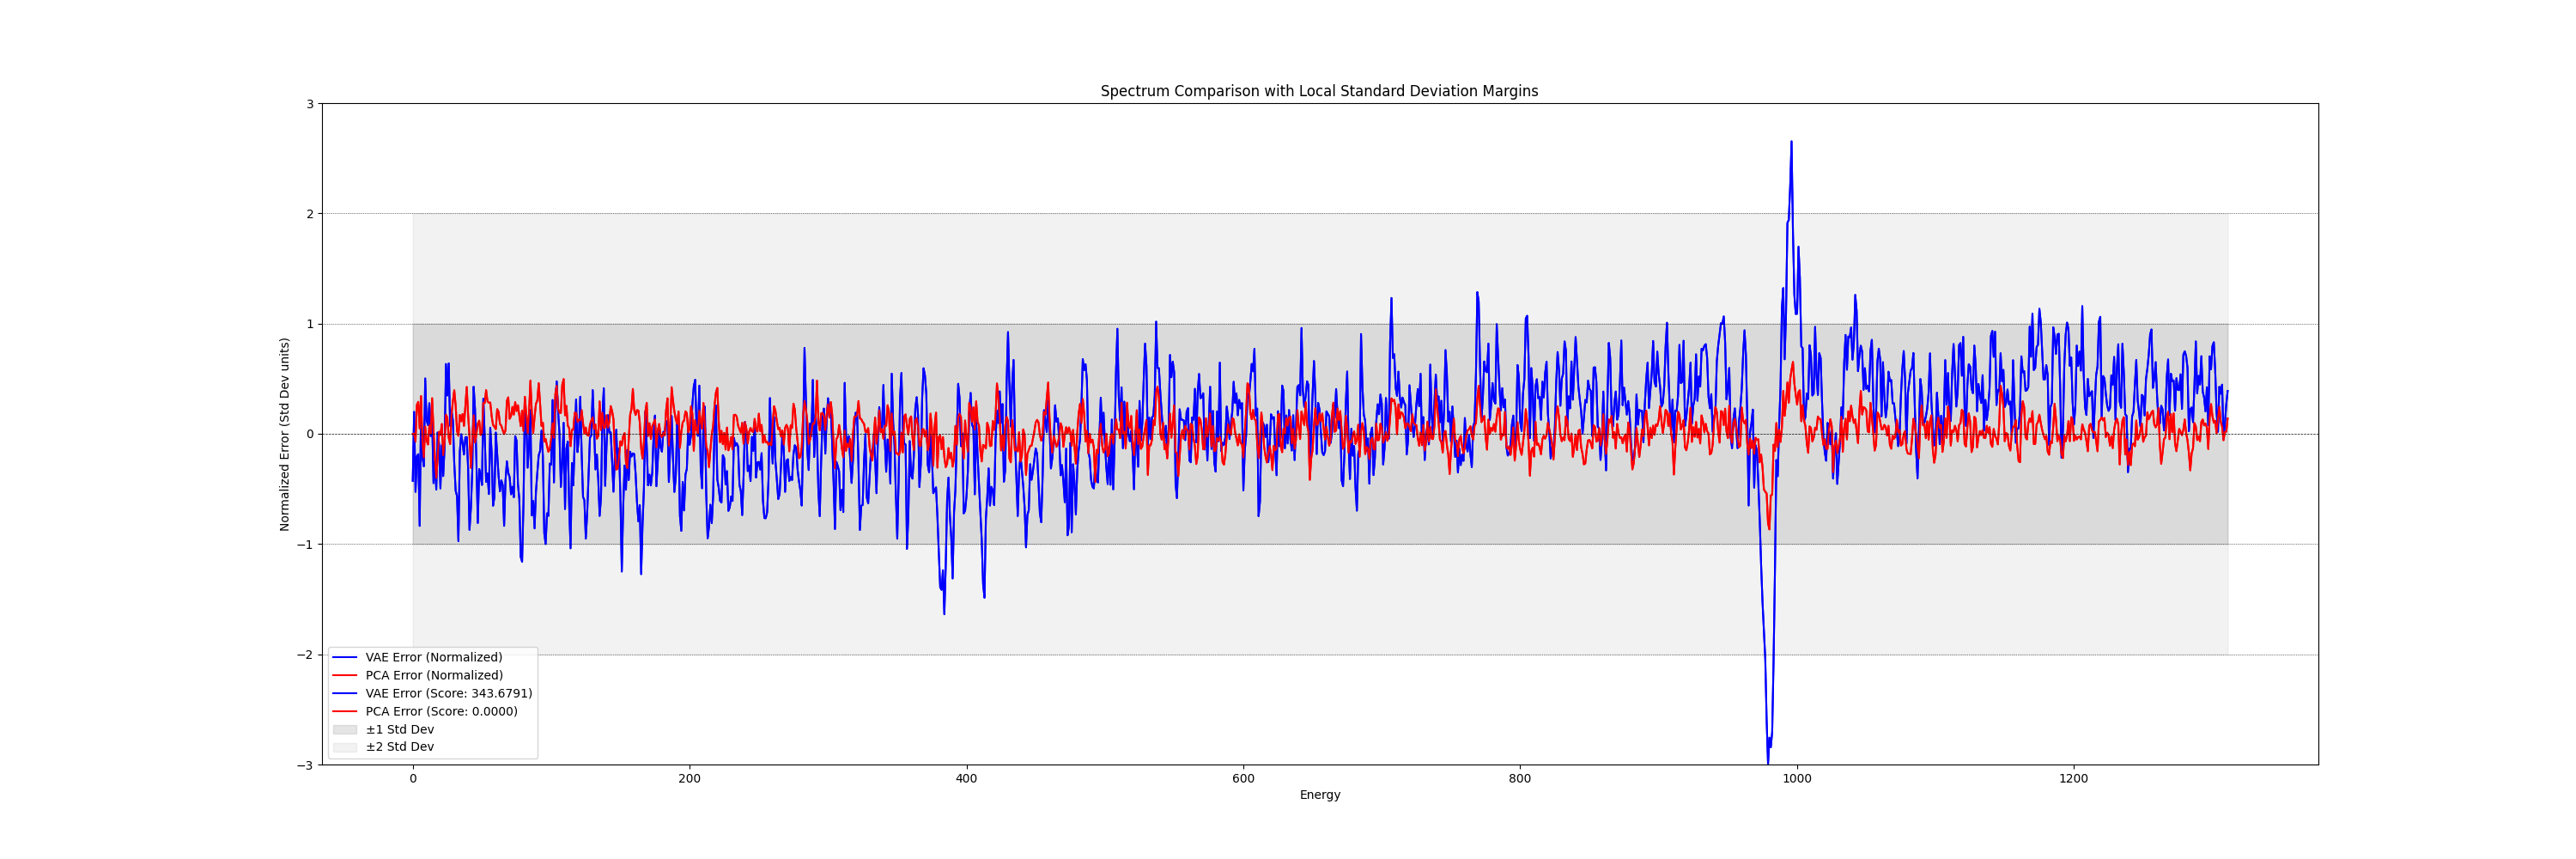

Percentage of VAE error within 1 std dev: 95.58%
Percentage of VAE error within 2 std dev: 99.31%
Percentage of PCA error within 1 std dev: 100.00%
Percentage of PCA error within 2 std dev: 100.00%


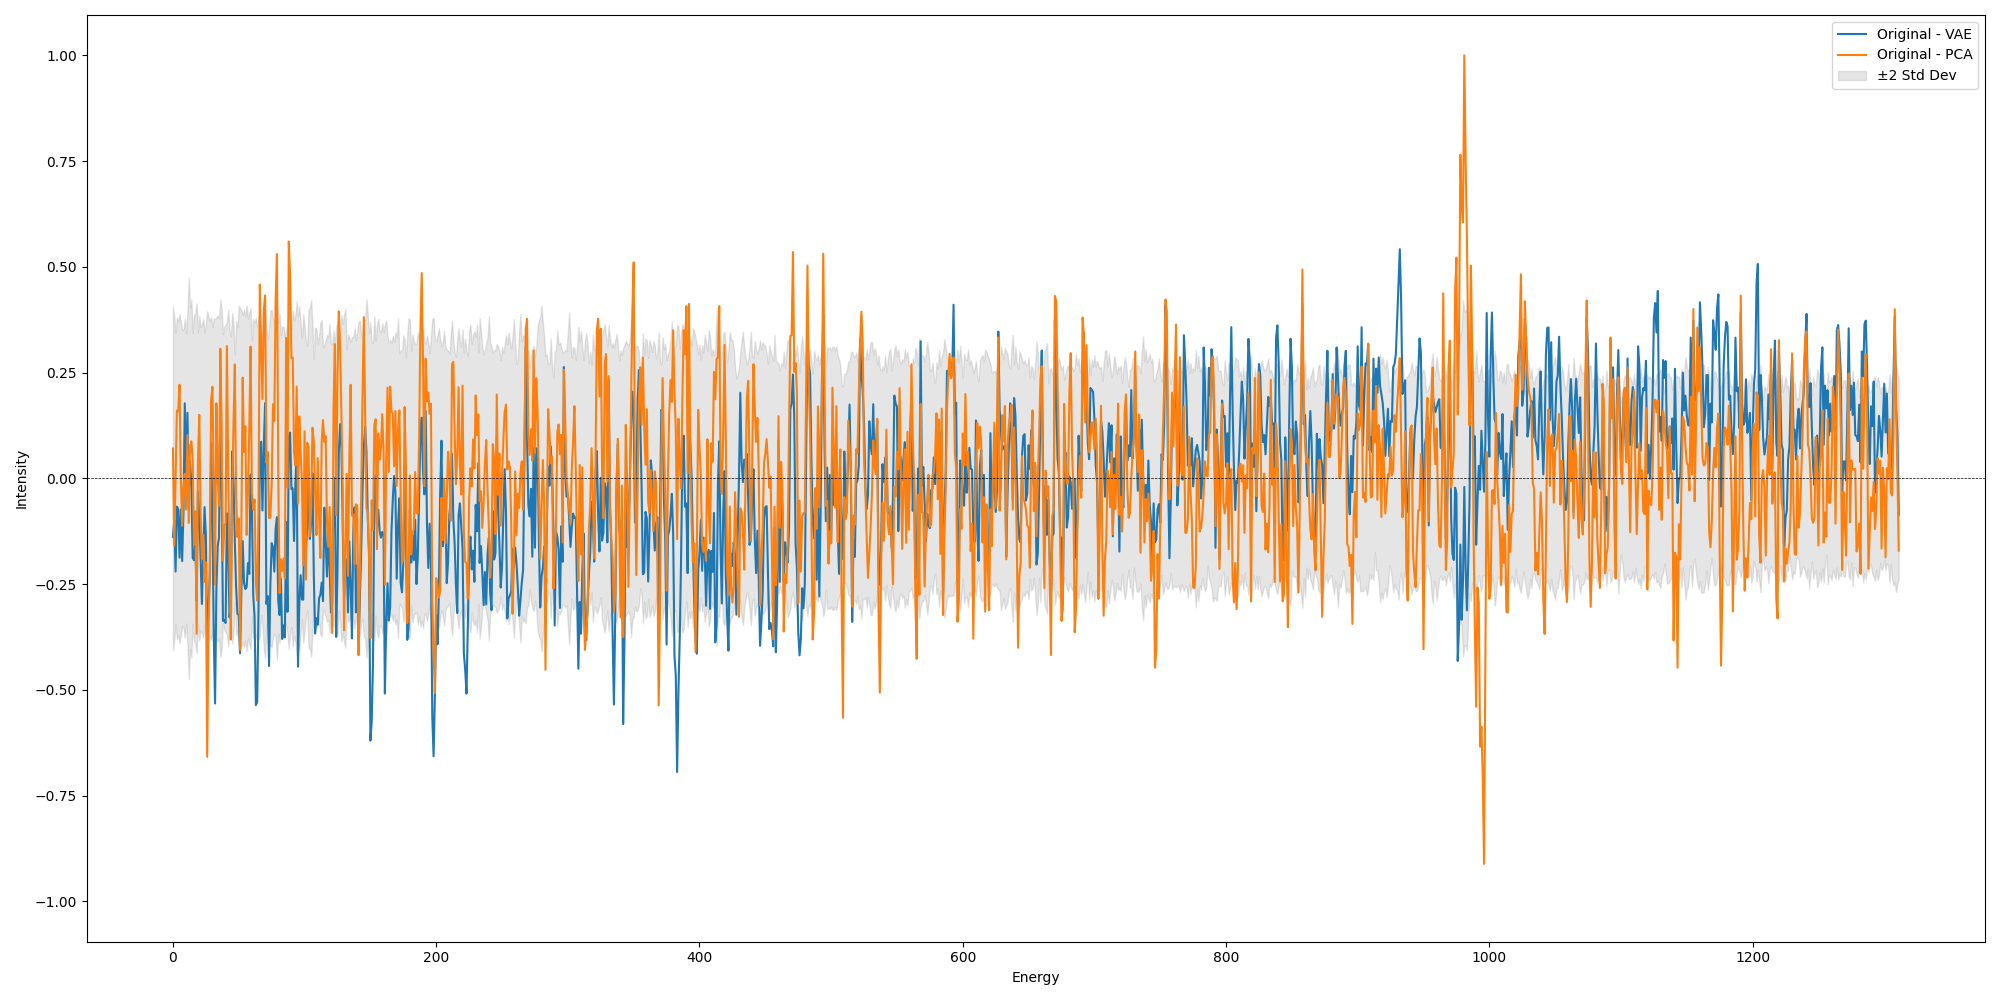

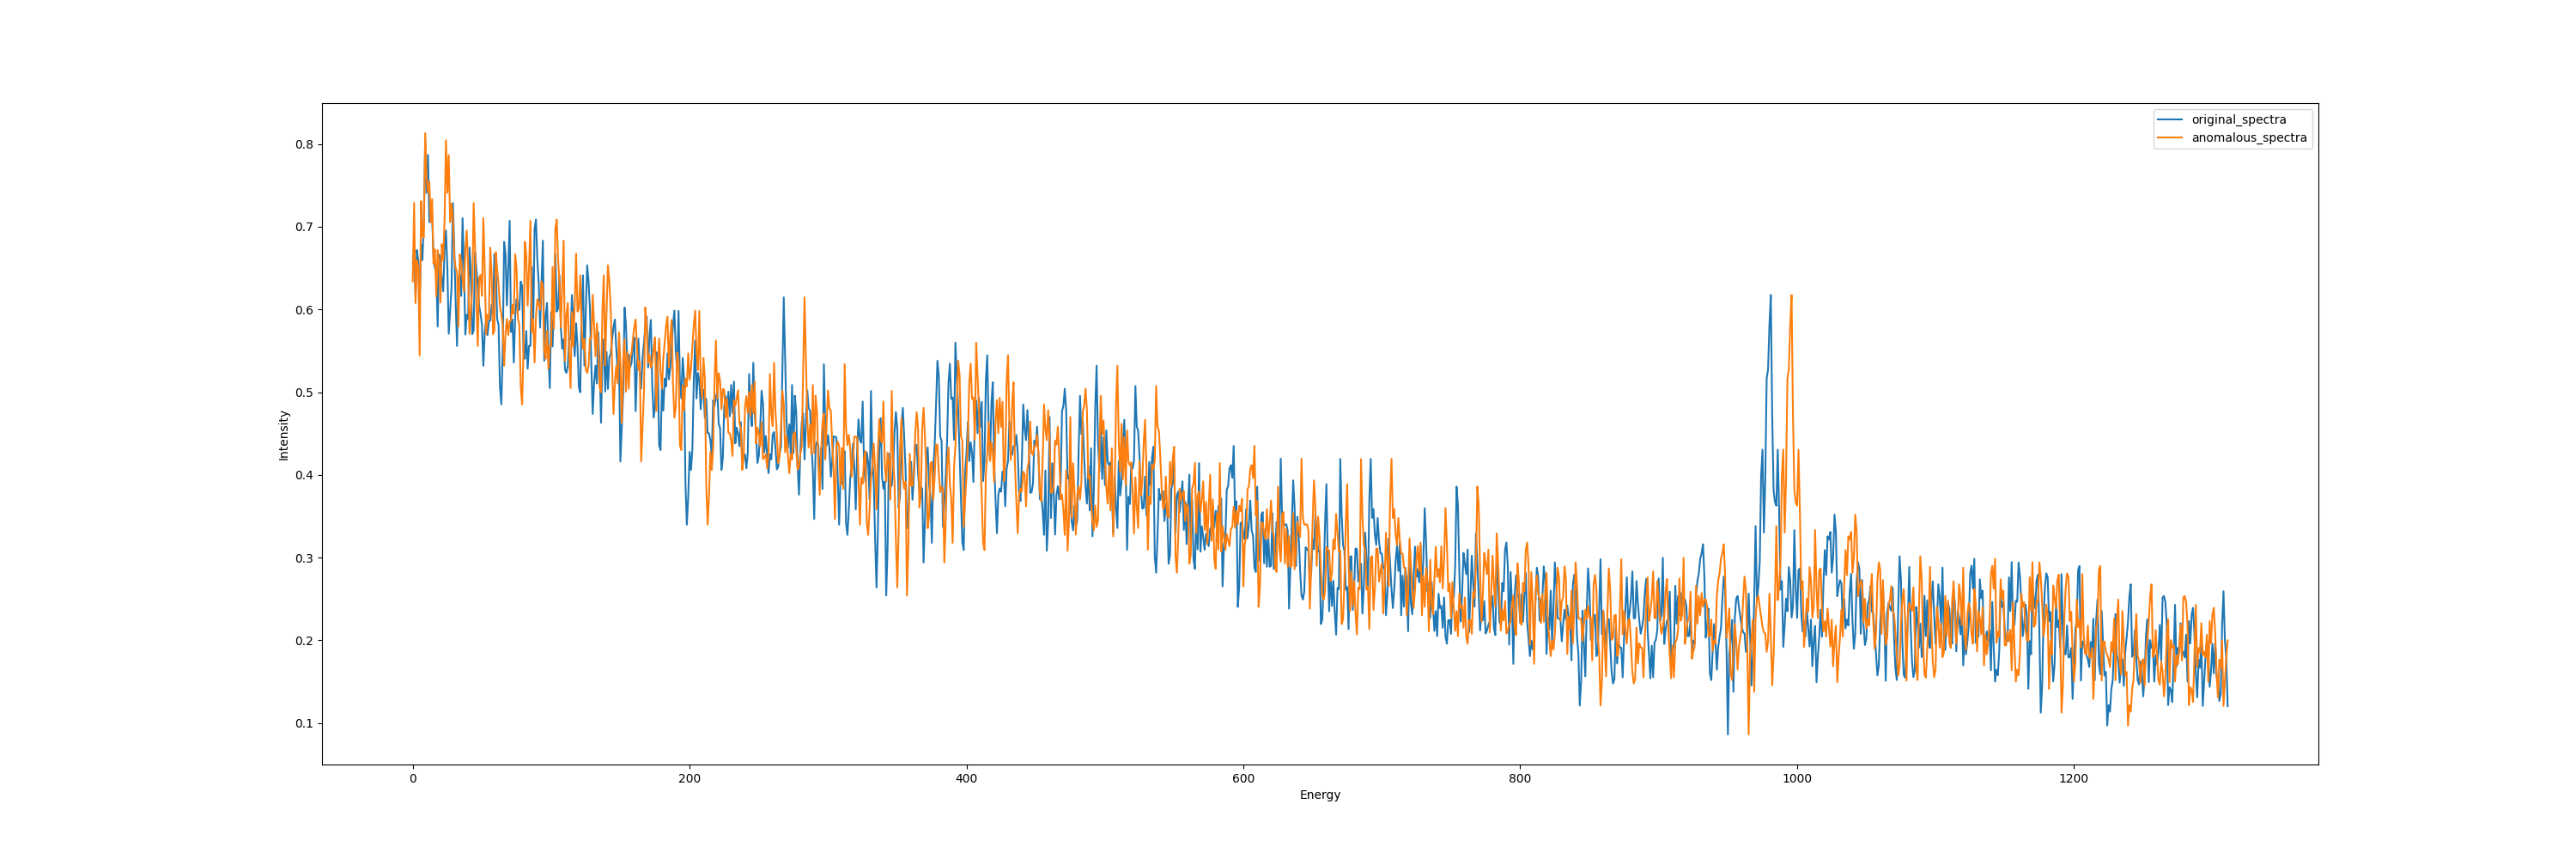

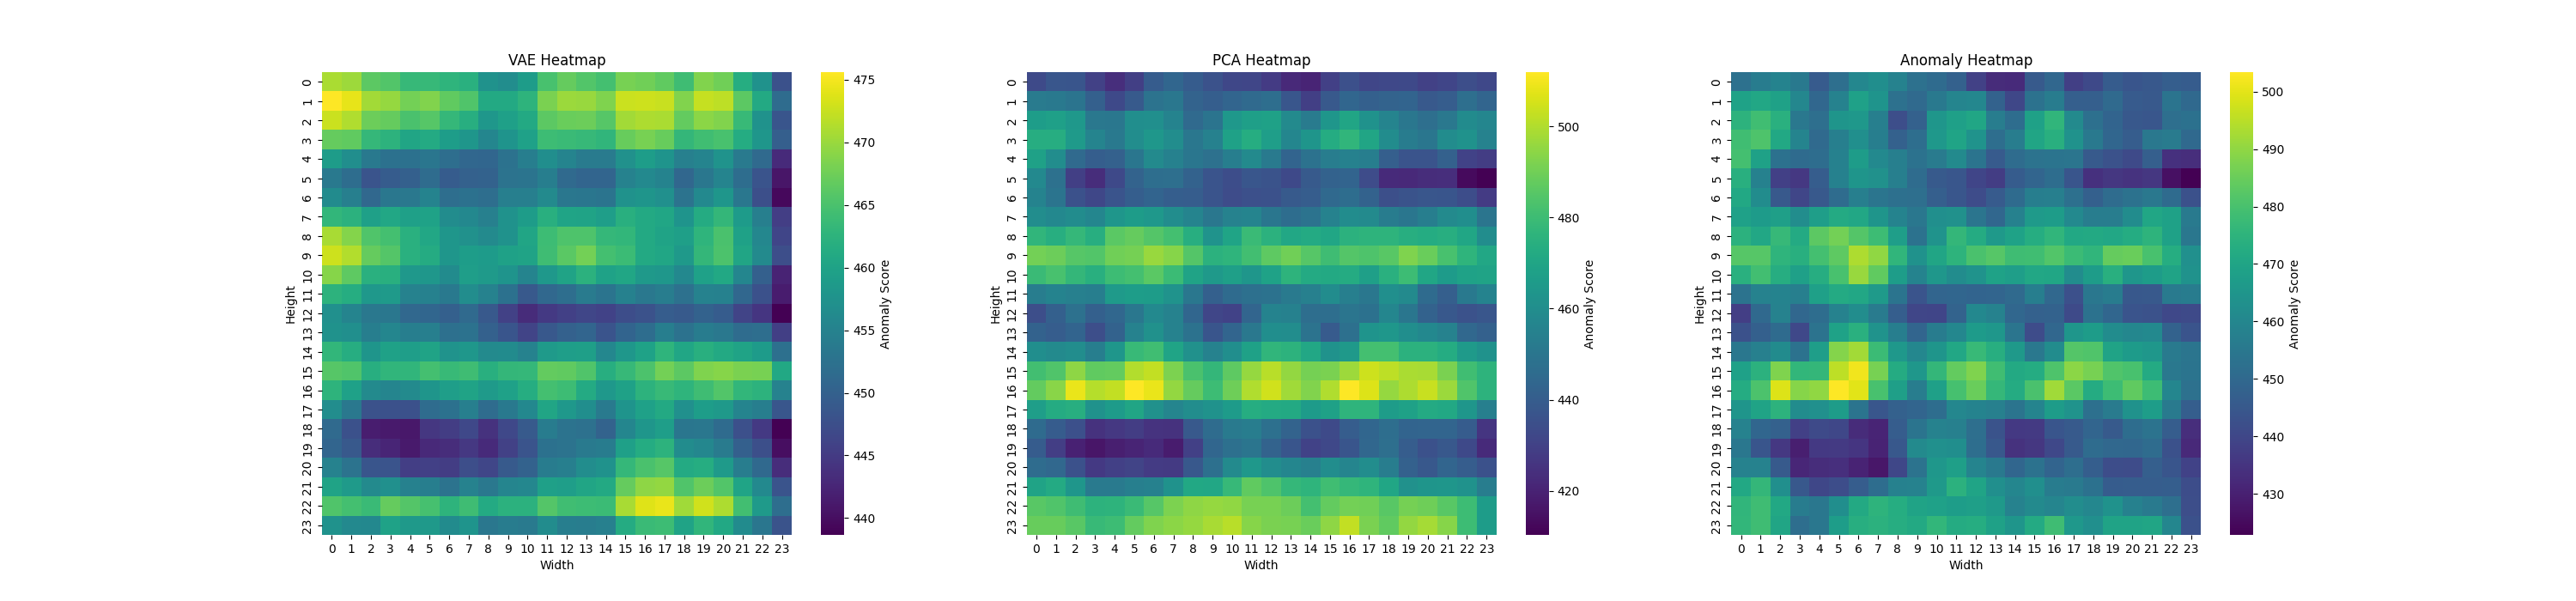

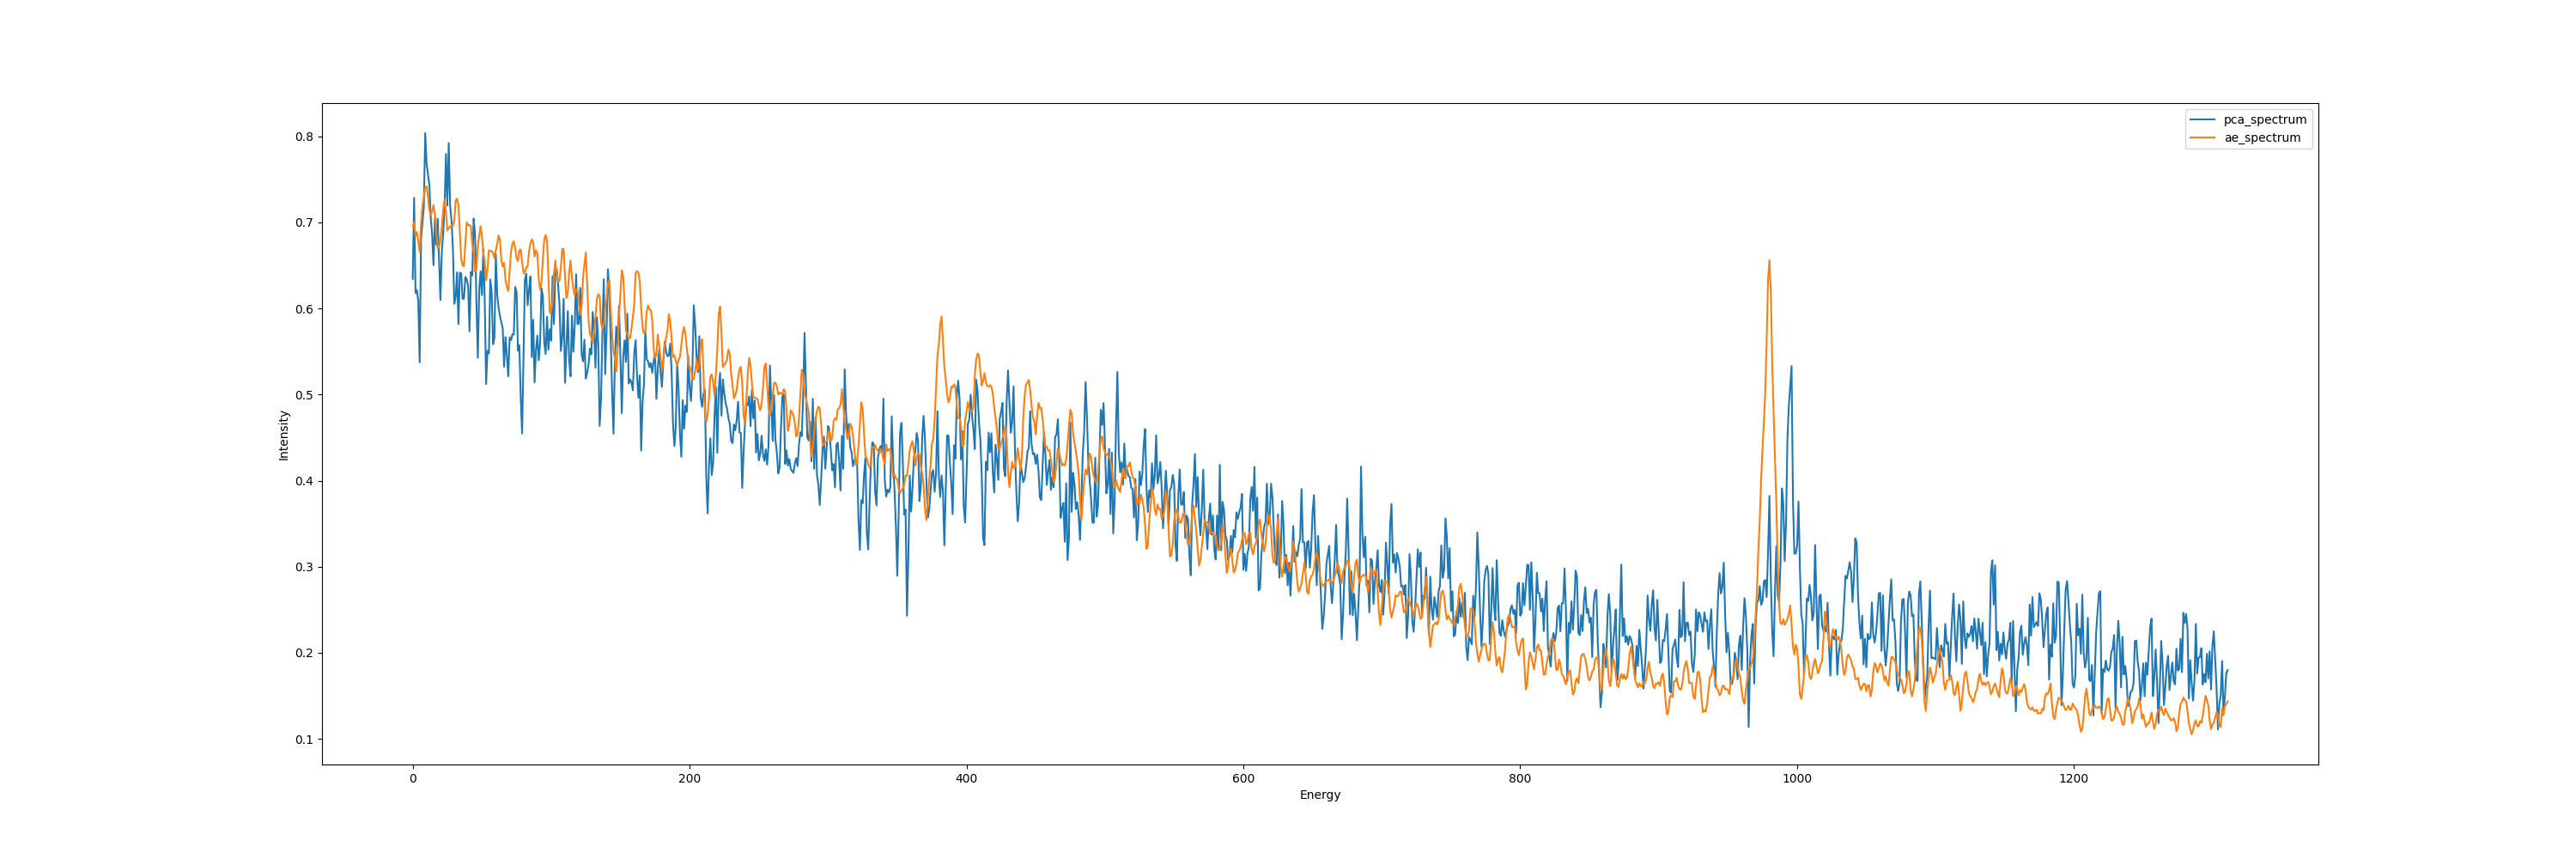

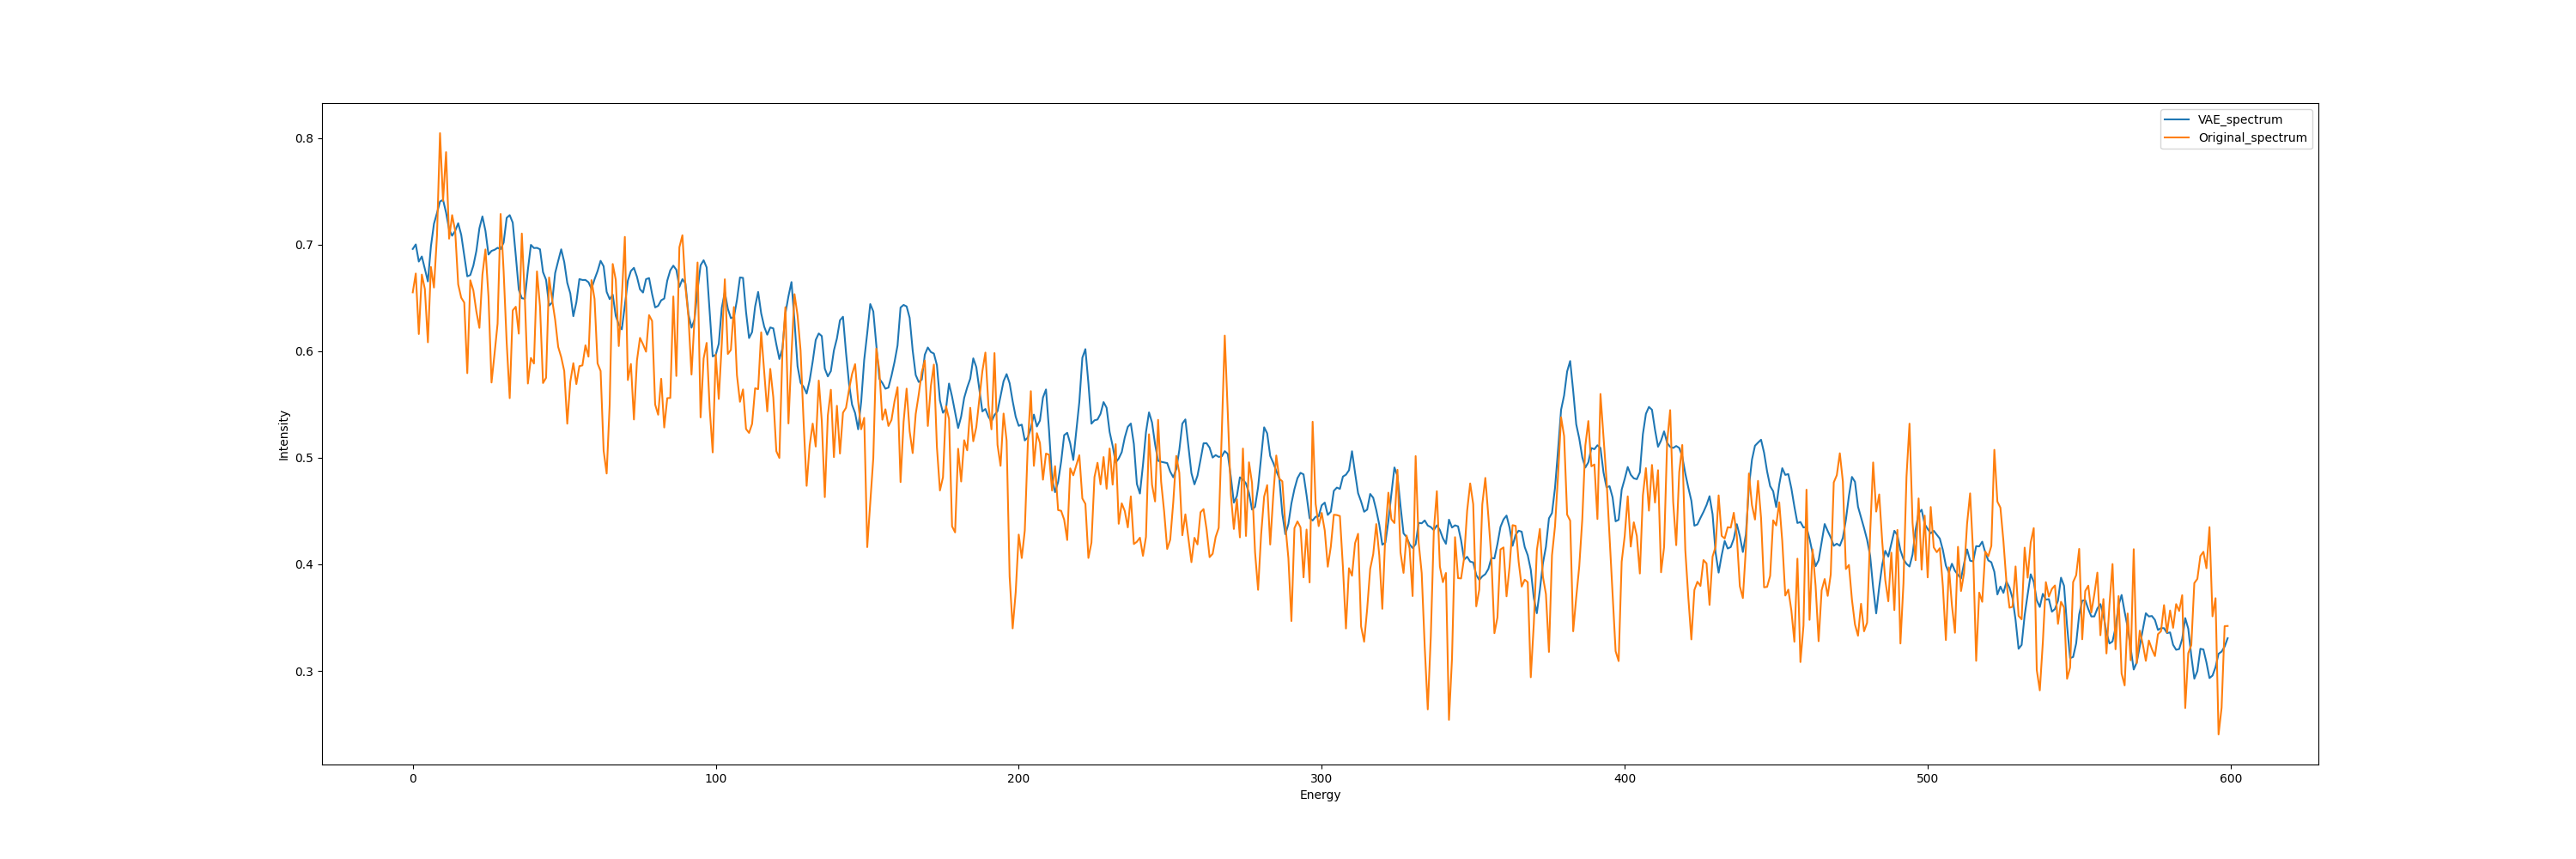

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from dtaidistance import dtw
import pandas as pd
import seaborn as sns

def inject_anomalies(image, num_clusters=5, cluster_size=4, shift_amount=15, noise_factor=0.09, peak_reduction_factor=0.1, peak_reduction_probability=0):
    """
    Inject anomalies into the EELS image with added noise and peak reduction options.
    
    Args:
    image (numpy.ndarray): Input image of shape (height, width, energy_channels)
    num_clusters (int): Number of anomalous clusters to inject
    cluster_size (int): Size of each anomalous cluster
    shift_amount (int): Amount to shift the peak (in energy channels)
    noise_factor (float): Factor to control the amount of noise added (0 to 1)
    peak_reduction_factor (float): Factor to reduce peak intensity (0 to 1)
    peak_reduction_probability (float): Probability of applying peak reduction to a cluster (0 to 1)
    
    Returns:
    tuple: (anomalous_image, anomaly_mask)
        anomalous_image (numpy.ndarray): Image with injected anomalies, noise, and peak reductions
        anomaly_mask (numpy.ndarray): Boolean mask indicating anomalous pixels
    """
    anomalous_image = np.copy(image)
    height, width, channels = image.shape
    anomaly_mask = np.zeros((height, width), dtype=bool)
    
    # Add global noise
    noise = np.random.normal(0, noise_factor * np.mean(image), image.shape)
    anomalous_image += noise
    
    for _ in range(num_clusters):
        # Choose a random center for the cluster
        center_y = np.random.randint(cluster_size, height - cluster_size)
        center_x = np.random.randint(cluster_size, width - cluster_size)
        
        # Define the cluster region
        y_start, y_end = center_y - cluster_size // 2, center_y + cluster_size // 2 + 1
        x_start, x_end = center_x - cluster_size // 2, center_x + cluster_size // 2 + 1
        
        # Mark the cluster region as anomalous
        anomaly_mask[y_start:y_end, x_start:x_end] = True
        
        # Shift the peak
        if np.random.random() < 0.5:  # 50% chance to shift left or right
            anomalous_image[y_start:y_end, x_start:x_end, :-shift_amount] = image[y_start:y_end, x_start:x_end, shift_amount:]
        else:
            anomalous_image[y_start:y_end, x_start:x_end, shift_amount:] = image[y_start:y_end, x_start:x_end, :-shift_amount]
        
        # Randomly reduce peak intensity
        if np.random.random() < peak_reduction_probability:
            peak_intensity = np.max(anomalous_image[y_start:y_end, x_start:x_end])
            reduction_amount = peak_intensity * peak_reduction_factor
            anomalous_image[y_start:y_end, x_start:x_end] -= reduction_amount
    
    # Ensure all values are non-negative
    anomalous_image = np.clip(anomalous_image, 0, None)
    
    return anomalous_image, anomaly_mask

def compare_spectra(model, input_data, sub_image_index, coordinate=(12, 12), device='cuda', n_pca_fit=30, n_pca_reconstruct=5, threshold=1.75):
    """
    Compare original, anomalous, and reconstructed spectra using DTW.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    sub_image_index (int): Index of the sub-image to visualize
    coordinate (tuple): The (x, y) coordinate of the spectrum to analyze
    device (str): The device to run the model on ('cuda' or 'cpu')
    n_pca_fit (int): Number of PCA components to fit
    n_pca_reconstruct (int): Number of PCA components to use for reconstruction
    
    Returns:
    None (displays the plot)
    """
    # Select the sub-image and inject anomalies
    input_sub_image = input_data[sub_image_index] # (24, 24, 1312)
    anomalous_sub_image, _ = inject_anomalies(input_sub_image) # FOR TESTING 
    # anomalous_sub_image = input_sub_image # FOR TESTING 

    # Extract the spectrum at the given coordinate
    x, y = coordinate
    original_spectrum = input_sub_image[x, y]
    anomalous_spectrum = anomalous_sub_image[x, y] # FOR TESTING 

    # Create a modified version of input_data with the anomalous sub-image
    modified_input_data = input_data.copy()
    modified_input_data[sub_image_index] = anomalous_sub_image

    # Plot the anomaly spectrum 
    fig, ax0 = plt.subplots(figsize=(30, 10))
    ax0.plot(original_spectrum, label="original_spectra")
    ax0.plot(anomalous_spectrum, label='anomalous_spectra')
    ax0.set_xlabel("Energy")
    ax0.set_ylabel("Intensity")
    ax0.legend()
    
    # Generate VAE prediction for anomalous data
    with torch.no_grad():
        anomalous_tensor = torch.tensor(anomalous_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        mean, logvar = model.encode(anomalous_tensor)
        z = model.reparameterize(mean, logvar)
        prediction_sub_image = model.decode(z).squeeze().cpu().numpy()
    ae_spectrum = prediction_sub_image[x, y]
    
    # Perform PCA
    pca = PCA(n_components=n_pca_fit)
    flattened_data = modified_input_data.reshape(modified_input_data.shape[0], -1)
    pca_result = pca.fit_transform(flattened_data)
    
    # Reconstruct using only the top n_pca_reconstruct components
    top_components = pca_result[:, :n_pca_reconstruct]
    reduced_components = pca.components_[:n_pca_reconstruct, :]
    pca_reconstruction = np.dot(top_components, reduced_components) + pca.mean_
    pca_reconstruction = pca_reconstruction.reshape(modified_input_data.shape)
    pca_spectrum = pca_reconstruction[sub_image_index, x, y]

    # Plotting
    fig, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(30, 7))

    # original heatmap 
    sns.heatmap(np.sum(anomalous_sub_image, axis=-1), ax=ax5, cmap='viridis', cbar_kws={'label': 'Anomaly Score'})
    ax5.set_title('Anomaly Heatmap')
    ax5.set_xlabel('Width')
    ax5.set_ylabel('Height')

    # VAE Heatmap
    sns.heatmap(np.sum(prediction_sub_image, axis=-1), ax=ax3, cmap='viridis', cbar_kws={'label': 'Anomaly Score'})
    ax3.set_title('VAE Heatmap')
    ax3.set_xlabel('Width')
    ax3.set_ylabel('Height')
    
    # PCA Heatmap
    sns.heatmap(np.sum(pca_reconstruction[sub_image_index], axis=-1), ax=ax4, cmap='viridis', cbar_kws={'label': 'Anomaly Score'})
    ax4.set_title('PCA Heatmap')
    ax4.set_xlabel('Width')
    ax4.set_ylabel('Height')

    fig, ax0 = plt.subplots(figsize=(30, 10))
    ax0.plot(pca_spectrum, label="pca_spectrum")
    ax0.plot(ae_spectrum, label='ae_spectrum')
    ax0.set_xlabel("Energy")
    ax0.set_ylabel("Intensity")
    ax0.legend()

    fig, ax1 = plt.subplots(figsize=(30, 10))
    ax1.plot(ae_spectrum[:600], label="VAE_spectrum")
    ax1.plot(original_spectrum[:600], label='Original_spectrum')
    ax1.set_xlabel("Energy")
    ax1.set_ylabel("Intensity")
    ax1.legend()

    # Calculate differences
    vae_diff = anomalous_spectrum - ae_spectrum
    pca_diff = anomalous_spectrum - pca_spectrum

    # Calculate local standard deviation
    local_std = np.std(anomalous_spectrum)

    # Normalize differences by local standard deviation
    vae_diff_normalized = vae_diff / local_std
    pca_diff_normalized = pca_diff / local_std

    # Plotting
    fig, ax = plt.subplots(figsize=(30, 10))
    
    # Plot the normalized differences
    ax.plot(vae_diff_normalized, label="VAE Error (Normalized)", color='blue')
    ax.plot(pca_diff_normalized, label="PCA Error (Normalized)", color='red')

    # Calculate anomaly scores
    def calculate_anomaly_score(diff_normalized):
        # Apply progressive penalization
        penalties = np.where(np.abs(diff_normalized) > threshold,
                             np.abs(diff_normalized) * np.power(np.abs(diff_normalized), np.abs(diff_normalized)),
                             0)
                
        # Calculate the anomaly score
        anomaly_score = np.sum(penalties)
        
        return anomaly_score
    
    vae_anomaly_score = calculate_anomaly_score(vae_diff_normalized)
    pca_anomaly_score = calculate_anomaly_score(pca_diff_normalized)
    
    # Plot the normalized differences
    ax.plot(vae_diff_normalized, label=f"VAE Error (Score: {vae_anomaly_score:.4f})", color='blue')
    ax.plot(pca_diff_normalized, label=f"PCA Error (Score: {pca_anomaly_score:.4f})", color='red')
    
    # Plot standard deviation margins
    x_axis = range(len(vae_diff_normalized))
    ax.fill_between(x_axis, -1, 1, alpha=0.2, color='gray', label='±1 Std Dev')
    ax.fill_between(x_axis, -2, 2, alpha=0.1, color='gray', label='±2 Std Dev')

    ax.set_xlabel("Energy")
    ax.set_ylabel("Normalized Error (Std Dev units)")
    ax.legend()

    # Set y-axis limits
    y_limit = max(3, np.abs(vae_diff_normalized).max(), np.abs(pca_diff_normalized).max())
    ax.set_ylim(-y_limit, y_limit)

    # Add horizontal lines at y=0, y=±1, and y=±2 for reference
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axhline(y=1, color='k', linestyle=':', linewidth=0.5)
    ax.axhline(y=-1, color='k', linestyle=':', linewidth=0.5)
    ax.axhline(y=2, color='k', linestyle=':', linewidth=0.5)
    ax.axhline(y=-2, color='k', linestyle=':', linewidth=0.5)

    plt.title("Spectrum Comparison with Local Standard Deviation Margins")
    plt.show()

    # Print summary statistics
    print(f"Percentage of VAE error within 1 std dev: {np.mean(np.abs(vae_diff_normalized) <= 1) * 100:.2f}%")
    print(f"Percentage of VAE error within 2 std dev: {np.mean(np.abs(vae_diff_normalized) <= 2) * 100:.2f}%")
    print(f"Percentage of PCA error within 1 std dev: {np.mean(np.abs(pca_diff_normalized) <= 1) * 100:.2f}%")
    print(f"Percentage of PCA error within 2 std dev: {np.mean(np.abs(pca_diff_normalized) <= 2) * 100:.2f}%")

    # Plotting
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.subplots_adjust(wspace=0.3)
    n_std_dev = 2
    
    vae_diff = original_spectrum - ae_spectrum
    pca_diff = original_spectrum - pca_spectrum

    # Center each difference around its own mean
    vae_diff_centered = vae_diff - np.mean(vae_diff)
    pca_diff_centered = pca_diff - np.mean(pca_diff)

    # Calculate standard deviation across all spectra
    all_spectra = input_data[:, x, y]  # Shape: (num_sub_images, energy)
    std_dev = np.std(all_spectra, axis=0)

    # Find the maximum absolute value across both centered differences
    max_abs_val = max(np.abs(vae_diff_centered).max(), 
                  np.abs(pca_diff_centered).max(), 
                  n_std_dev * np.abs(std_dev).max())

    # Scale both differences to the range [-1, 1]
    vae_diff_scaled = vae_diff_centered / max_abs_val
    pca_diff_scaled = pca_diff_centered / max_abs_val
    std_dev_scaled = std_dev / max_abs_val

    # Plot the scaled differences
    ax.plot(vae_diff_scaled, label="Original - VAE")
    ax.plot(pca_diff_scaled, label="Original - PCA")

    x_axis = range(len(vae_diff_scaled))
    ax.fill_between(x_axis, 
                -n_std_dev * std_dev_scaled, 
                n_std_dev * std_dev_scaled, 
                alpha=0.2, 
                color='gray', 
                label=f'±{n_std_dev} Std Dev')

    ax.set_xlabel("Energy")
    ax.set_ylabel("Intensity")
    ax.legend()

    # Set y-axis limits to ensure symmetry around 0
    y_limit = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
    ax.set_ylim(-y_limit, y_limit)

    # Add a horizontal line at y=0 for reference
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)

    # def calculate_adaptive_spectrum_score(original_spectrum, diff, window_size=5, base_factor=0.5, adaptive_factor=1.5):
    #     # Calculate the standard deviation of the original spectrum
    #     spectrum_std = np.std(original_spectrum)
        
    #     # Set a base threshold
    #     base_threshold = base_factor * spectrum_std
        
    #     # Calculate an adaptive threshold based on the local variability of the difference
    #     local_std = np.array([np.std(diff[max(0, i-window_size):i+window_size+1]) 
    #                         for i in range(len(diff))])
    #     adaptive_threshold = base_threshold + adaptive_factor * local_std
        
    #     # Create a mask for differences exceeding the adaptive threshold
    #     anomaly_mask = np.abs(diff) > adaptive_threshold
        
    #     # Apply the mask to the difference
    #     thresholded_diff = diff * anomaly_mask
        
    #     # Calculate basic statistics on the thresholded difference
    #     mse = np.mean(np.square(thresholded_diff))
    #     max_deviation = np.max(np.abs(thresholded_diff))
        
    #     # Calculate rolling standard deviation to detect sharp changes
    #     rolling_std = np.array([np.std(thresholded_diff[max(0, i-window_size):i+1]) 
    #                             for i in range(len(thresholded_diff))])
        
    #     # Penalize large deviations more heavily
    #     large_deviation_penalty = np.mean(np.power(np.abs(thresholded_diff), 4))
        
    #     # Penalize sharp changes
    #     sharpness_penalty = np.mean(np.square(rolling_std))
        
    #     # Calculate the percentage of points considered anomalous
    #     anomaly_percentage = np.mean(anomaly_mask) * 100
        
    #     # Combine the components into a final score
    #     score = mse + 2 * large_deviation_penalty + sharpness_penalty + max_deviation
        
    #     # If no anomalies were detected, use a small non-zero score based on the original difference
    #     if score == 0:
    #         score = np.mean(np.abs(diff)) / spectrum_std
        
    #     return score, anomaly_percentage, np.mean(adaptive_threshold)

    # # Assuming we have the original spectrum and the differences
    # vae_score, vae_anomaly_percent, vae_threshold = calculate_adaptive_spectrum_score(denoised_spectrum, vae_diff)
    # pca_score, pca_anomaly_percent, pca_threshold = calculate_adaptive_spectrum_score(denoised_spectrum, pca_diff)

    # print(f"VAE Score: {vae_score:.6f} (Anomaly: {vae_anomaly_percent:.2f}%)")
    # print(f"PCA Score: {pca_score:.6f} (Anomaly: {pca_anomaly_percent:.2f}%)")

    # # Determine which method performed better
    # better_method = "VAE" if vae_score < pca_score else "PCA"
    # print(f"The {better_method} method performed better (lower score is better).")

    # # Plot these scores on your existing graph
    # axs[0].text(0.05, 0.95, f"VAE Score: {vae_score:.6f} ({vae_anomaly_percent:.2f}%)", 
    #             transform=axs[3].transAxes, verticalalignment='top', fontsize=8)
    # axs[0].text(0.05, 0.90, f"PCA Score: {pca_score:.6f} ({pca_anomaly_percent:.2f}%)", 
    #             transform=axs[3].transAxes, verticalalignment='top', fontsize=8)

    # # Visualize the mean threshold
    # axs[0].axhline(y=vae_threshold, color='r', linestyle='--', linewidth=0.5)
    # axs[0].axhline(y=-vae_threshold, color='r', linestyle='--', linewidth=0.5)
    # axs[0].text(0.05, 0.85, f"Mean Threshold: ±{vae_threshold:.6f}", transform=axs[3].transAxes, 
    #             verticalalignment='top', fontsize=8, color='red')
    
    plt.tight_layout()
    plt.show()

# Usage example:
compare_spectra(model, dataset, sub_image_index=12, coordinate=(12, 12), device="cuda", n_pca_fit=30, n_pca_reconstruct=5)

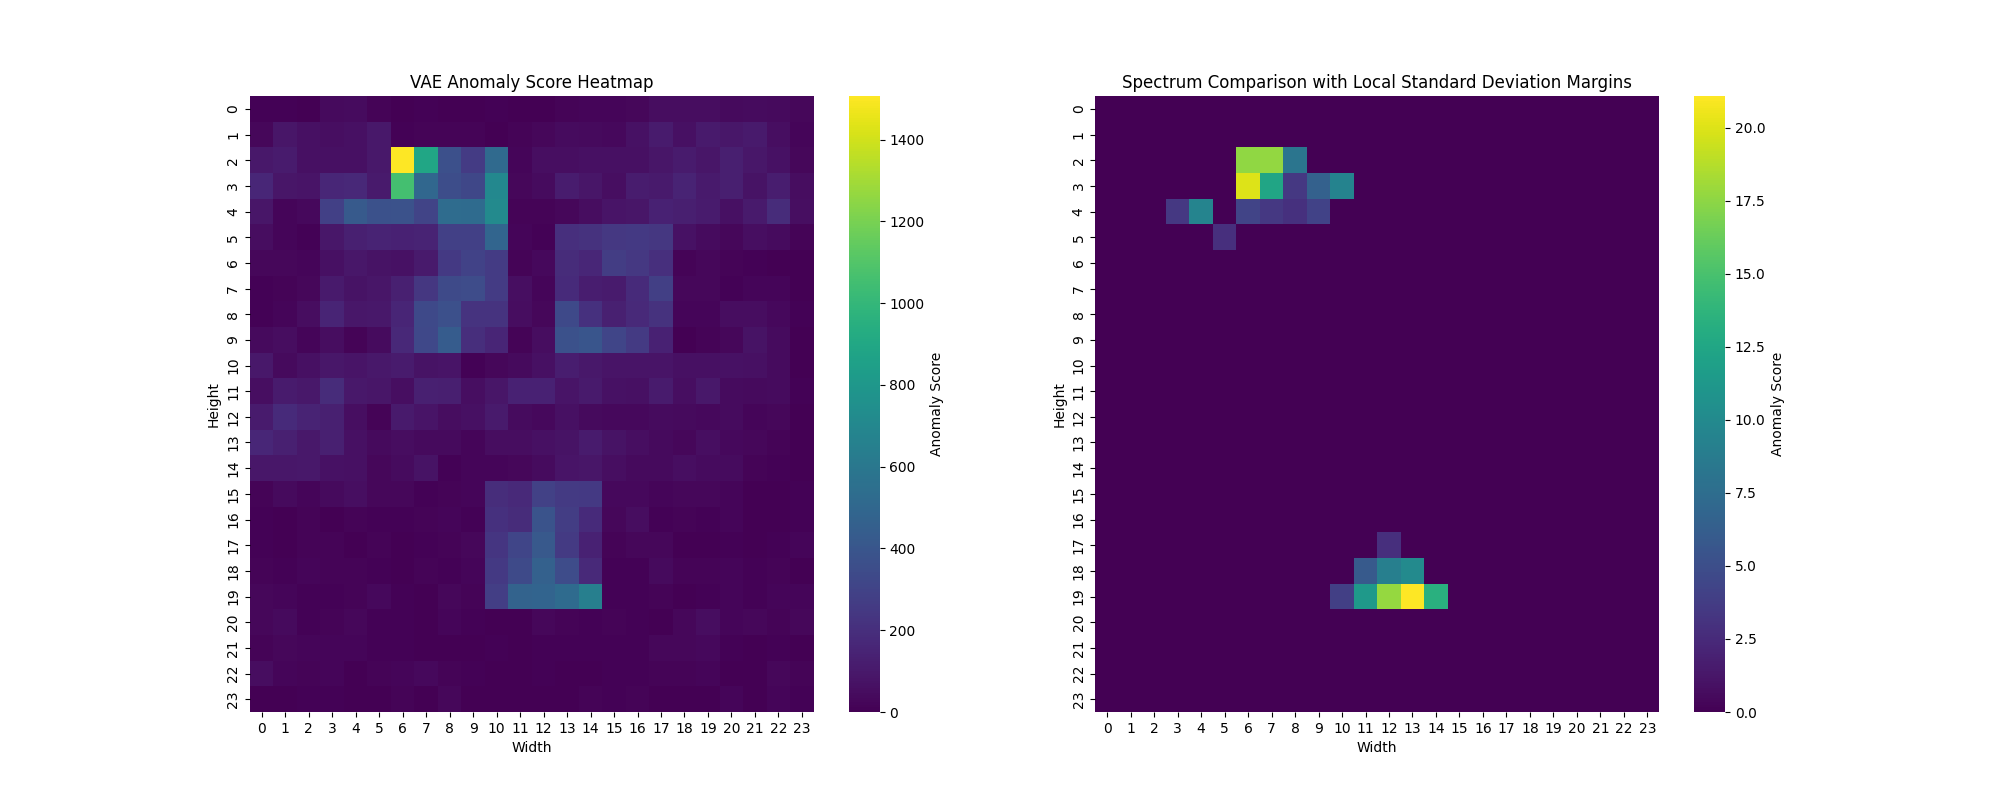

Percentage of VAE error within 1 std dev: 95.20%
Percentage of VAE error within 2 std dev: 100.00%
Percentage of PCA error within 1 std dev: 99.85%
Percentage of PCA error within 2 std dev: 100.00%


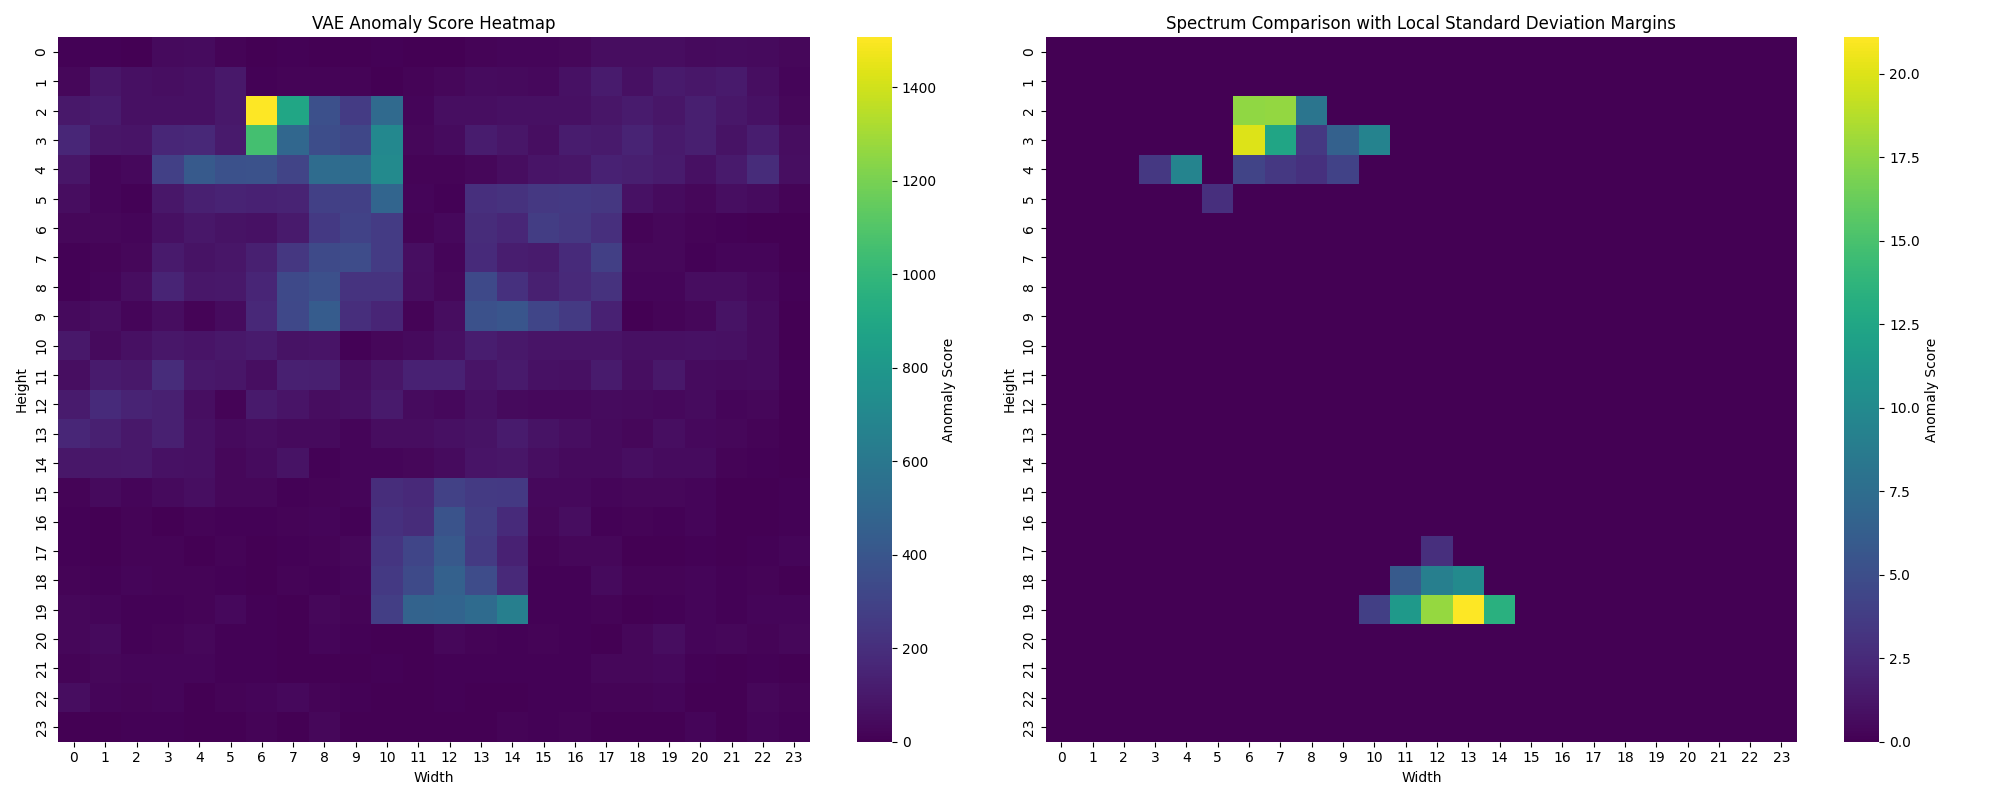

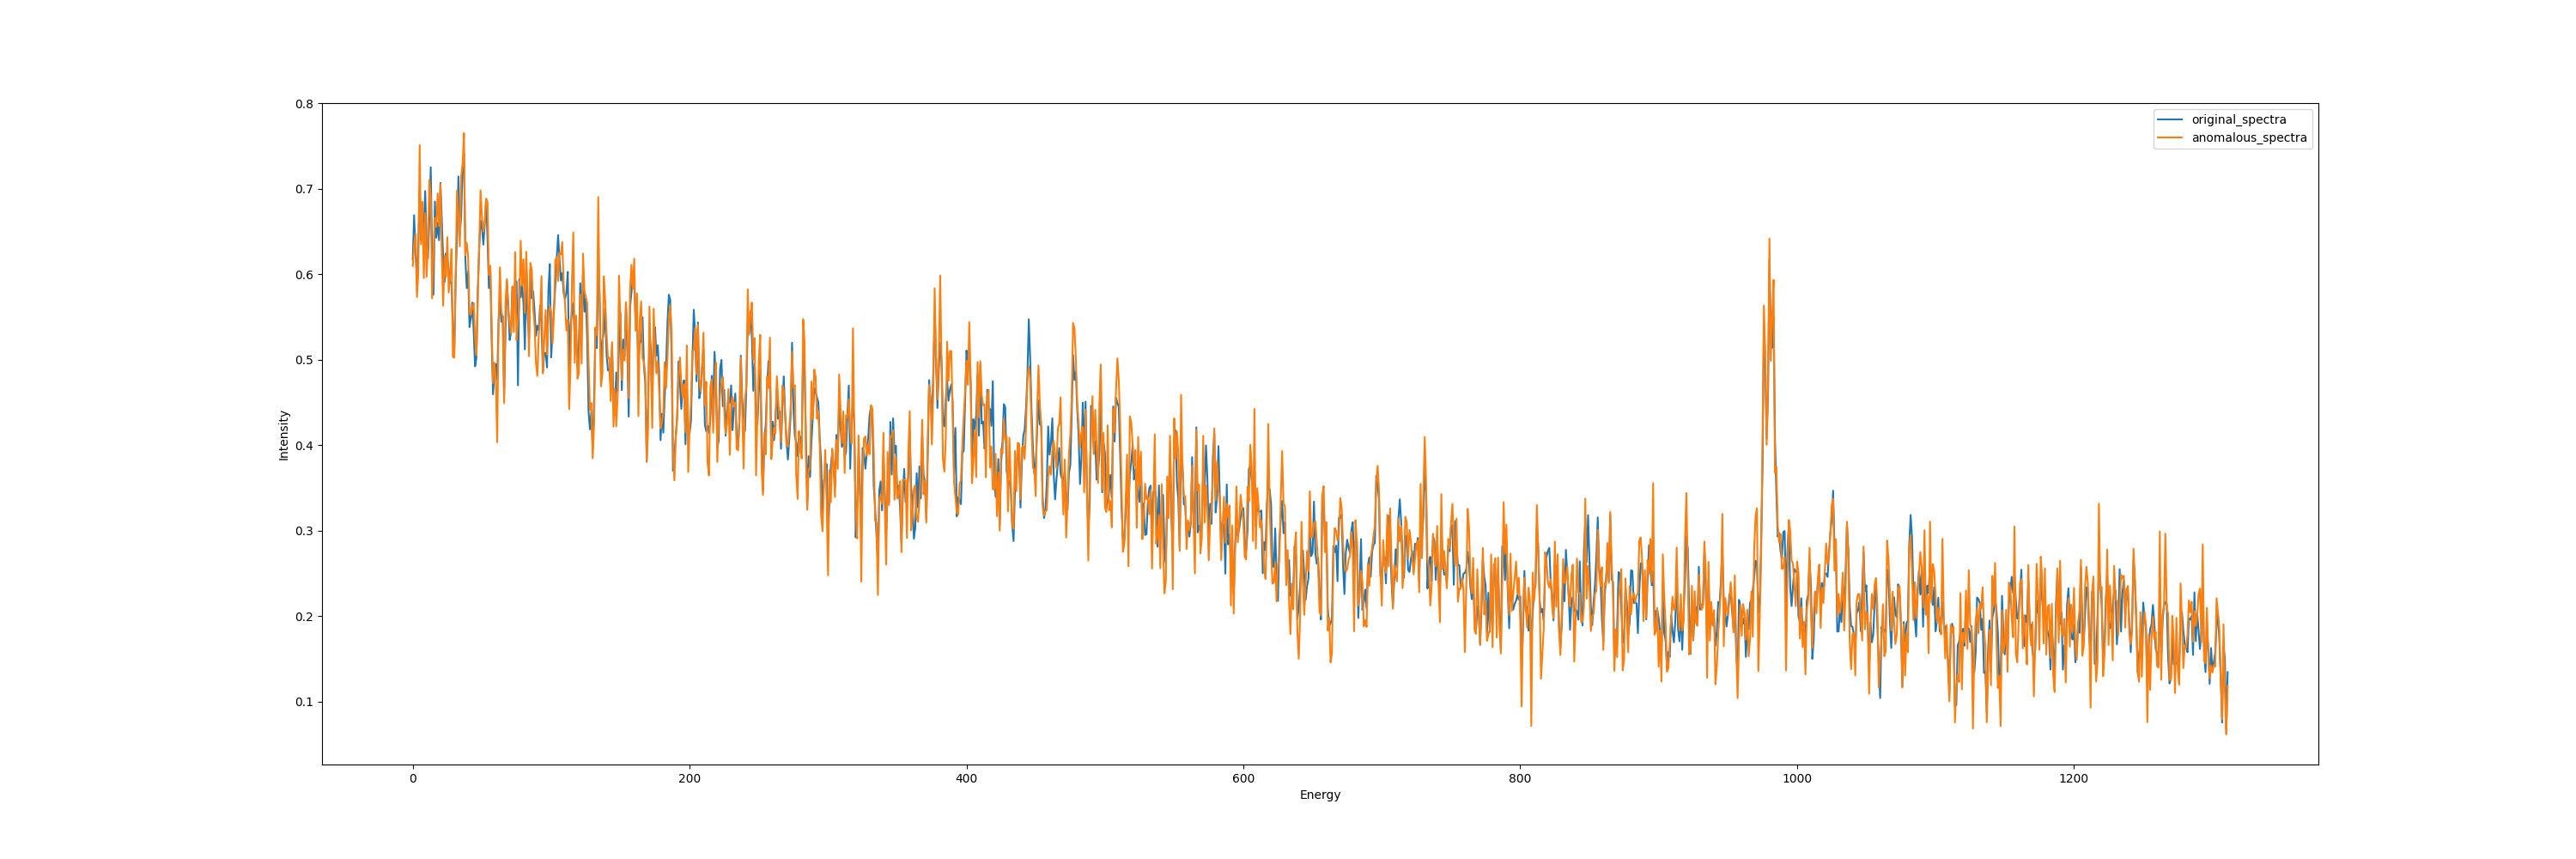

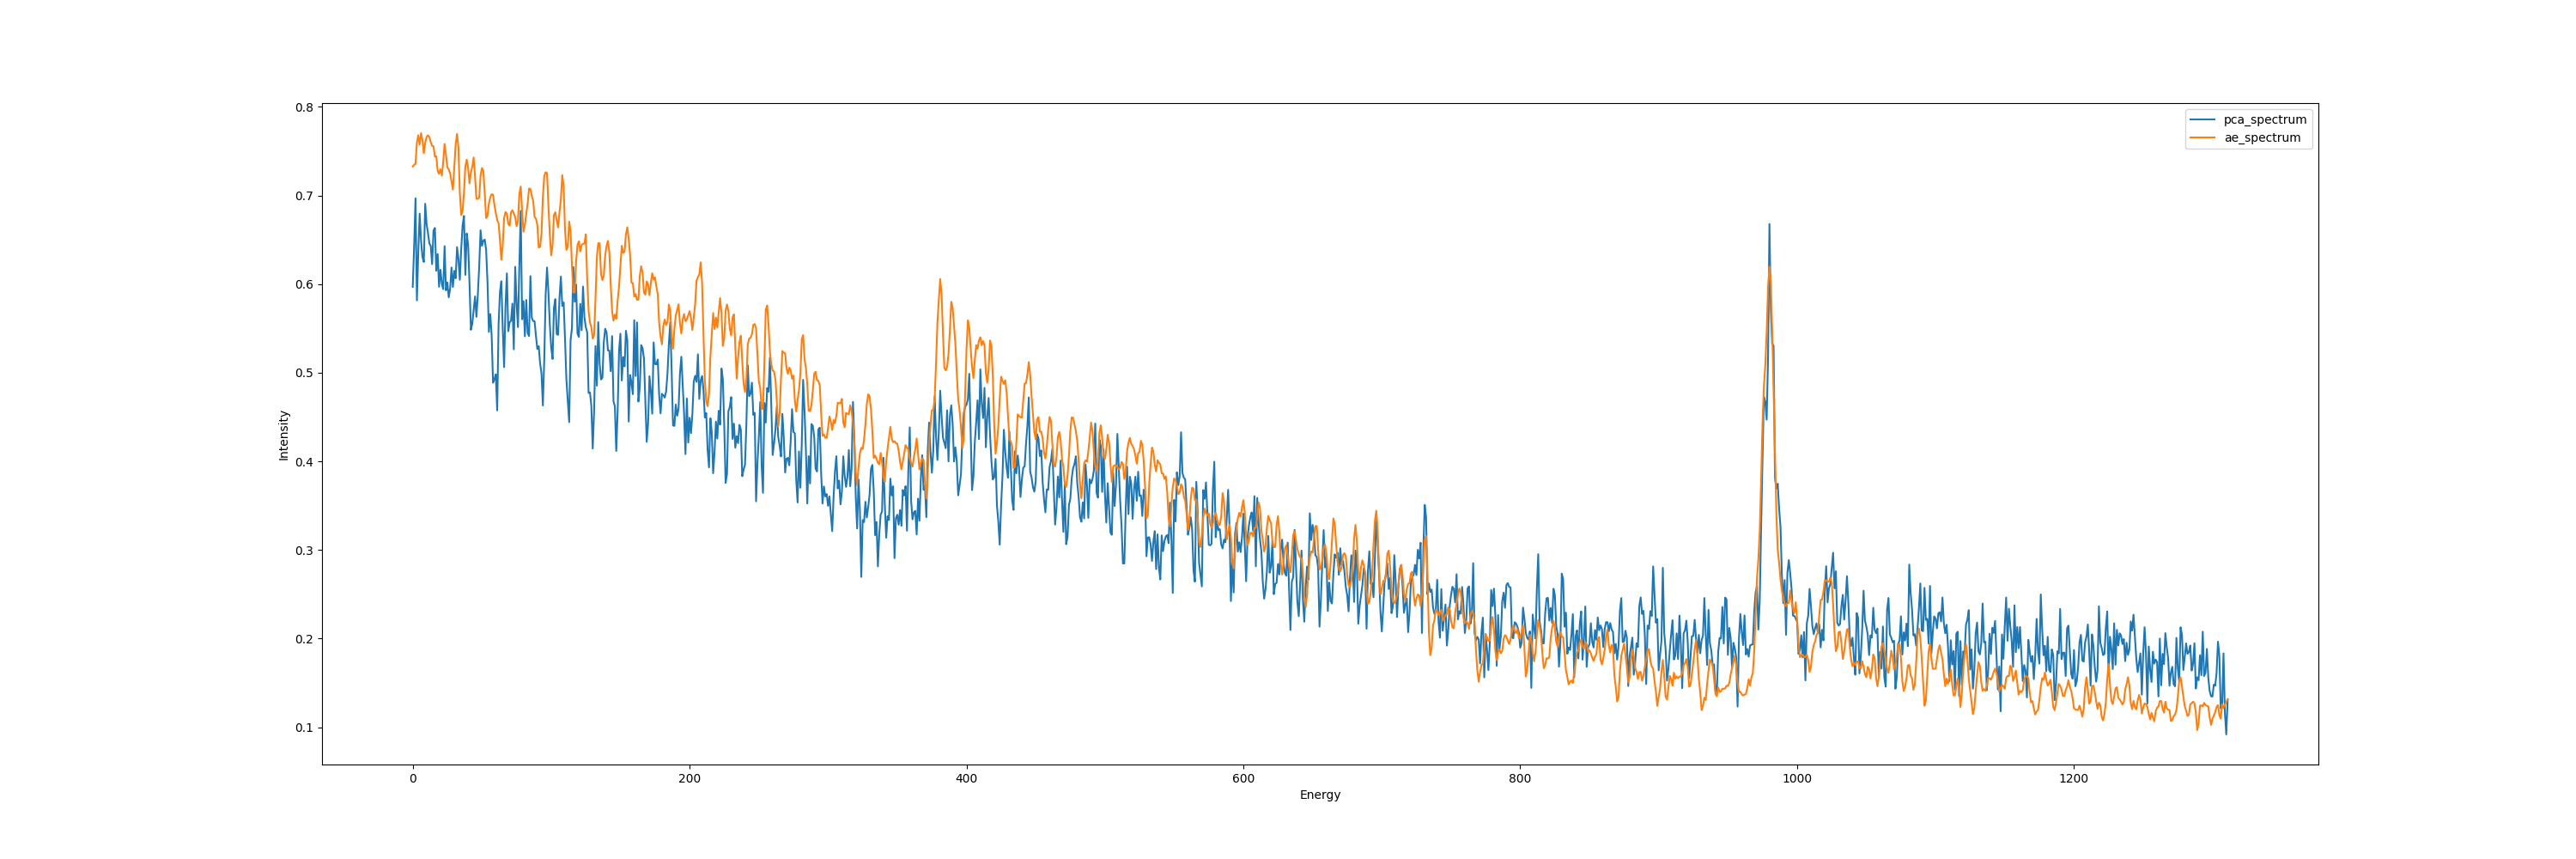

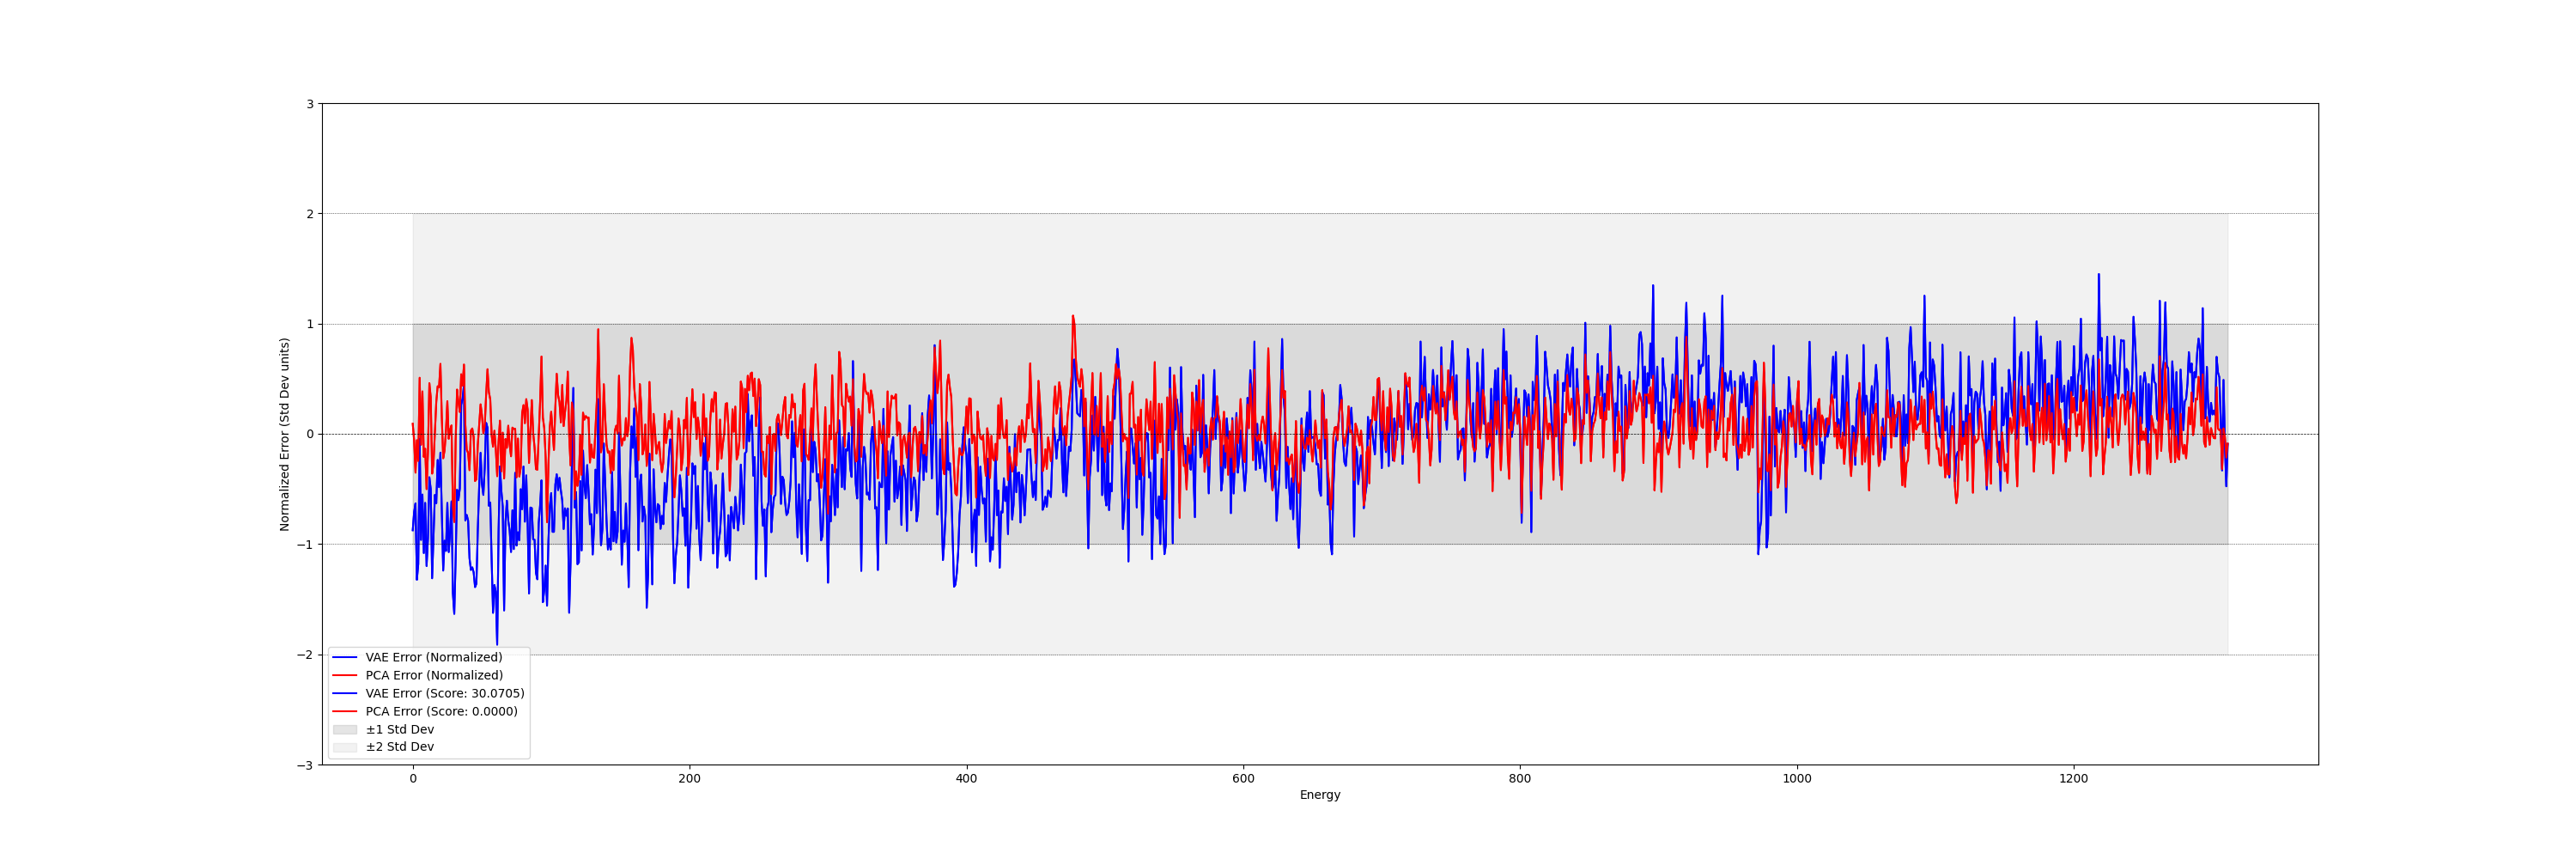

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
import seaborn as sns

def compare_spectra(model, input_data, sub_image_index, coordinate=(12, 12), device='cuda', n_pca_fit=30, n_pca_reconstruct=5, threshold=1.5):
    """
    Compare original, anomalous, and reconstructed spectra using DTW.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    sub_image_index (int): Index of the sub-image to visualize
    coordinate (tuple): The (x, y) coordinate of the spectrum to analyze
    device (str): The device to run the model on ('cuda' or 'cpu')
    n_pca_fit (int): Number of PCA components to fit
    n_pca_reconstruct (int): Number of PCA components to use for reconstruction
    
    Returns:
    None (displays the plot)
    """
    # Select the sub-image and inject anomalies
    input_sub_image = input_data[sub_image_index] # (24, 24, 1312)
    anomalous_sub_image, _ = inject_anomalies(input_sub_image) # FOR TESTING 
    # anomalous_sub_image = input_sub_image # FOR TESTING 
    
    # Extract the spectrum at the given coordinate
    x, y = coordinate
    original_spectrum = input_sub_image[x, y]
    anomalous_spectrum = anomalous_sub_image[x, y] # FOR TESTING 

    # Create a modified version of input_data with the anomalous sub-image
    modified_input_data = input_data.copy()
    modified_input_data[sub_image_index] = anomalous_sub_image

    # Plot the anomaly spectrum 
    fig, ax0 = plt.subplots(figsize=(30, 10))
    ax0.plot(original_spectrum, label="original_spectra")
    ax0.plot(anomalous_spectrum, label='anomalous_spectra')
    ax0.set_xlabel("Energy")
    ax0.set_ylabel("Intensity")
    ax0.legend()
    
    # Generate VAE prediction for anomalous data
    with torch.no_grad():
        anomalous_tensor = torch.tensor(anomalous_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        mean, logvar = model.encode(anomalous_tensor)
        z = model.reparameterize(mean, logvar)
        prediction_sub_image = model.decode(z).squeeze().cpu().numpy()
    ae_spectrum = prediction_sub_image[x, y]
    
    # Perform PCA
    pca = PCA(n_components=n_pca_fit)
    flattened_data = modified_input_data.reshape(modified_input_data.shape[0], -1)
    pca_result = pca.fit_transform(flattened_data)
    
    # Reconstruct using only the top n_pca_reconstruct components
    top_components = pca_result[:, :n_pca_reconstruct]
    reduced_components = pca.components_[:n_pca_reconstruct, :]
    pca_reconstruction = np.dot(top_components, reduced_components) + pca.mean_
    pca_reconstruction = pca_reconstruction.reshape(modified_input_data.shape)
    pca_spectrum = pca_reconstruction[sub_image_index, x, y]

    fig, ax0 = plt.subplots(figsize=(30, 10))
    ax0.plot(pca_spectrum, label="pca_spectrum")
    ax0.plot(ae_spectrum, label='ae_spectrum')
    ax0.set_xlabel("Energy")
    ax0.set_ylabel("Intensity")
    ax0.legend()

    # Calculate differences
    vae_diff = anomalous_spectrum - ae_spectrum
    pca_diff = anomalous_spectrum - pca_spectrum

    # Calculate local standard deviation
    local_std = np.std(anomalous_spectrum)

    # Normalize differences by local standard deviation
    vae_diff_normalized = vae_diff / local_std
    pca_diff_normalized = pca_diff / local_std

    # Plotting
    fig, ax = plt.subplots(figsize=(30, 10))
    
    # Plot the normalized differences
    ax.plot(vae_diff_normalized, label="VAE Error (Normalized)", color='blue')
    ax.plot(pca_diff_normalized, label="PCA Error (Normalized)", color='red')

    # Calculate anomaly scores
    def calculate_anomaly_score(diff_normalized):
        # Apply progressive penalization
        penalties = np.where(np.abs(diff_normalized) > threshold,
                             np.abs(diff_normalized) * np.power(np.abs(diff_normalized), np.abs(diff_normalized)),
                             0)
                
        # Calculate the anomaly score
        anomaly_score = np.sum(penalties)
        
        return anomaly_score
    
    vae_anomaly_score = calculate_anomaly_score(vae_diff_normalized)
    pca_anomaly_score = calculate_anomaly_score(pca_diff_normalized)
    
    # Plot the normalized differences
    ax.plot(vae_diff_normalized, label=f"VAE Error (Score: {vae_anomaly_score:.4f})", color='blue')
    ax.plot(pca_diff_normalized, label=f"PCA Error (Score: {pca_anomaly_score:.4f})", color='red')
    
    # Plot standard deviation margins
    x_axis = range(len(vae_diff_normalized))
    ax.fill_between(x_axis, -1, 1, alpha=0.2, color='gray', label='±1 Std Dev')
    ax.fill_between(x_axis, -2, 2, alpha=0.1, color='gray', label='±2 Std Dev')

    ax.set_xlabel("Energy")
    ax.set_ylabel("Normalized Error (Std Dev units)")
    ax.legend()

    # Set y-axis limits
    y_limit = max(3, np.abs(vae_diff_normalized).max(), np.abs(pca_diff_normalized).max())
    ax.set_ylim(-y_limit, y_limit)

    # Add horizontal lines at y=0, y=±1, and y=±2 for reference
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axhline(y=1, color='k', linestyle=':', linewidth=0.5)
    ax.axhline(y=-1, color='k', linestyle=':', linewidth=0.5)
    ax.axhline(y=2, color='k', linestyle=':', linewidth=0.5)
    ax.axhline(y=-2, color='k', linestyle=':', linewidth=0.5)

    height, width, _ = input_sub_image.shape
    vae_heatmap = np.zeros((height, width))
    pca_heatmap = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            anomalous_spectrum = anomalous_sub_image[i, j]
            vae_spectrum = prediction_sub_image[i, j]
            pca_spectrum = pca_reconstruction[sub_image_index, i, j]

            # Calculate differences
            vae_diff = anomalous_spectrum - vae_spectrum
            pca_diff = anomalous_spectrum - pca_spectrum

            # Calculate local standard deviation
            local_std = np.std(anomalous_spectrum)

            # Normalize differences by local standard deviation
            vae_diff_normalized = vae_diff / local_std
            pca_diff_normalized = pca_diff / local_std
            
            vae_heatmap[i, j] = calculate_anomaly_score(vae_diff_normalized)
            pca_heatmap[i, j] = calculate_anomaly_score(pca_diff_normalized)
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # VAE Heatmap
    sns.heatmap(vae_heatmap, ax=ax1, cmap='viridis', cbar_kws={'label': 'Anomaly Score'})
    ax1.set_title('VAE Anomaly Score Heatmap')
    ax1.set_xlabel('Width')
    ax1.set_ylabel('Height')

    # PCA Heatmap
    sns.heatmap(pca_heatmap, ax=ax2, cmap='viridis', cbar_kws={'label': 'Anomaly Score'})
    ax2.set_title('PCA Anomaly Score Heatmap')
    ax2.set_xlabel('Width')
    ax2.set_ylabel('Height')

    plt.title("Spectrum Comparison with Local Standard Deviation Margins")
    plt.show()

    # Print summary statistics
    print(f"Percentage of VAE error within 1 std dev: {np.mean(np.abs(vae_diff_normalized) <= 1) * 100:.2f}%")
    print(f"Percentage of VAE error within 2 std dev: {np.mean(np.abs(vae_diff_normalized) <= 2) * 100:.2f}%")
    print(f"Percentage of PCA error within 1 std dev: {np.mean(np.abs(pca_diff_normalized) <= 1) * 100:.2f}%")
    print(f"Percentage of PCA error within 2 std dev: {np.mean(np.abs(pca_diff_normalized) <= 2) * 100:.2f}%")

    plt.tight_layout()
    plt.show()

# Usage example:
compare_spectra(model, dataset, sub_image_index=19, coordinate=(12, 12), device="cuda", n_pca_fit=30, n_pca_reconstruct=4)

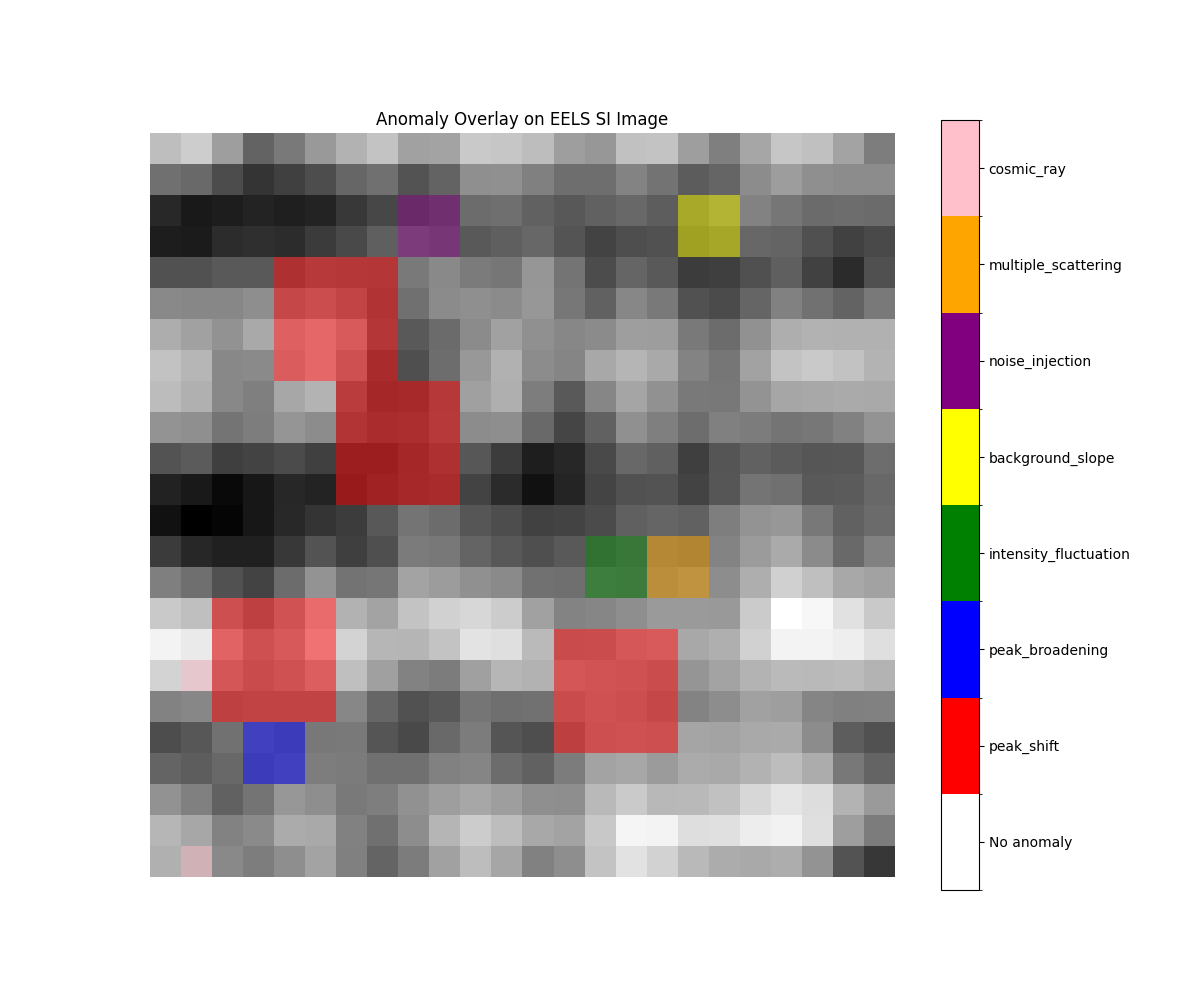

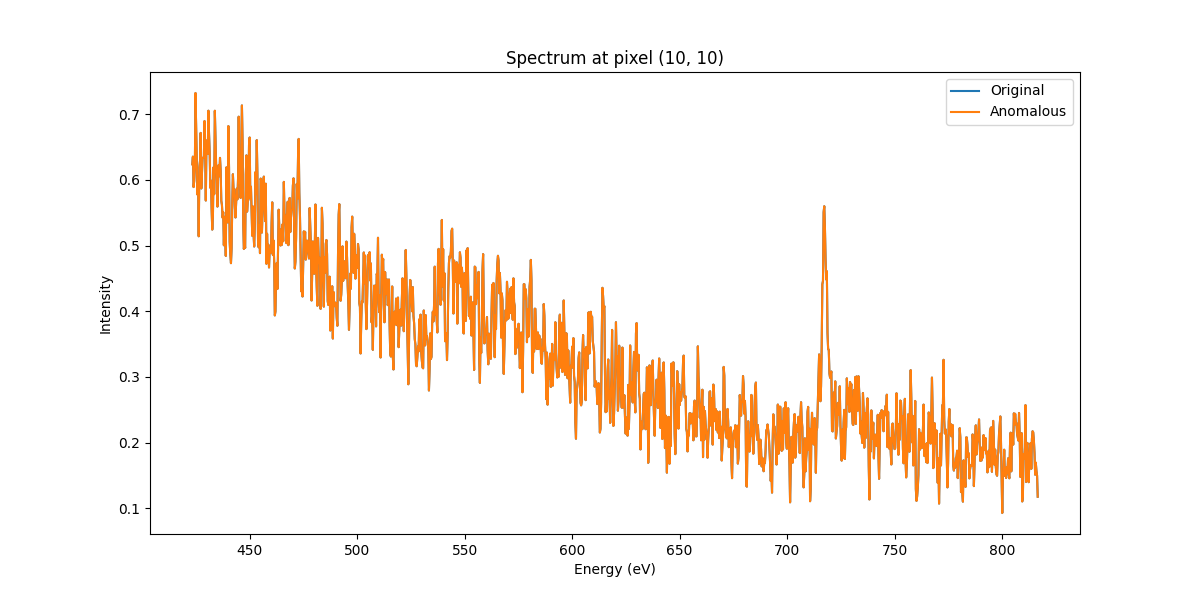

In [8]:
import numpy as np
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from scipy.signal import fftconvolve
import matplotlib.colors as mcolors

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def find_peaks(spectrum, prominence=0.1, distance=1, plot=False):
    """
    Find peaks in the spectrum using scipy's find_peaks function.
    
    Args:
    spectrum (numpy.ndarray): The input spectrum
    prominence (float): Minimum prominence of the peaks (relative to the maximum intensity)
    distance (int): Minimum distance between peaks
    plot (bool): If True, plot the spectrum with detected peaks
    
    Returns:
    tuple: (peak_positions, peak_properties)
    """
    prominence = prominence * np.max(spectrum)
    peaks, properties = signal.find_peaks(spectrum, prominence=prominence, distance=distance)
    
    if plot:
        plot_spectrum_with_peaks(spectrum, peaks, properties)
    
    return peaks, properties

def plot_spectrum_with_peaks(spectrum, peaks, properties):
    """
    Plot the spectrum with detected peaks.
    
    Args:
    spectrum (numpy.ndarray): The input spectrum
    peaks (numpy.ndarray): Array of peak indices
    properties (dict): Properties of the peaks
    """
    plt.figure(figsize=(12, 6))
    plt.plot(spectrum)
    plt.plot(peaks, spectrum[peaks], "x")
    
    # Highlighting the most prominent peak
    most_prominent = peaks[np.argmax(properties['prominences'])]
    plt.plot(most_prominent, spectrum[most_prominent], "o", color='red', markersize=10)
    
    plt.title("Spectrum with Detected Peaks (Red circle: Most Prominent)")
    plt.xlabel("Channel")
    plt.ylabel("Intensity")
    plt.show()

def find_main_peak(spectrum, plot=False):
    """
    Find the main peak in the spectrum based on highest prominence.
    
    Args:
    spectrum (numpy.ndarray): The input spectrum
    plot (bool): If True, plot the spectrum with the main peak
    
    Returns:
    int: The index of the main peak
    """
    peaks, properties = find_peaks(spectrum, prominence=0.1, distance=10)
    if len(peaks) == 0:
        main_peak = np.argmax(spectrum)
    else:
        # Select the peak with the highest prominence
        main_peak = peaks[np.argmax(properties['prominences'])]
    
    if plot:
        plot_spectrum_with_peaks(spectrum, [main_peak], {'prominences': [properties['prominences'][np.argmax(properties['prominences'])]]})
    
    return main_peak

def inject_controlled_anomalies(image, anomaly_specs):
    """
    Inject controlled anomalies into the EELS image.
    
    Args:
    image (numpy.ndarray): Input image of shape (height, width, energy_channels)
    anomaly_specs (list): List of tuples specifying anomalies: (type, count, cluster_size)
    
    Returns:
    tuple: (anomalous_image, anomaly_mask)
    """
    anomalous_image = np.copy(image)
    height, width, _ = image.shape
    anomaly_mask = np.zeros((height, width), dtype=int)
    
    anomaly_funcs = {
        'peak_shift': peak_shift,
        'peak_broadening': peak_broadening,
        'intensity_fluctuation': intensity_fluctuation,
        'background_slope': background_slope,
        'noise_injection': noise_injection,
        'multiple_scattering': multiple_scattering,
        'cosmic_ray': cosmic_ray
    }
    
    anomaly_colors = {
        'peak_shift': 1,
        'peak_broadening': 2,
        'intensity_fluctuation': 3,
        'background_slope': 4,
        'noise_injection': 5,
        'multiple_scattering': 6,
        'cosmic_ray': 7
    }
    
    for anomaly_type, count, cluster_size in anomaly_specs:
        for _ in range(count):
            if anomaly_type == 'cosmic_ray':
                # For cosmic ray, we only affect a single pixel
                while True:
                    y = np.random.randint(0, height)
                    x = np.random.randint(0, width)
                    if anomaly_mask[y, x] == 0:
                        anomaly_mask[y, x] = anomaly_colors[anomaly_type]
                        anomalous_image[y, x] = anomaly_funcs[anomaly_type](anomalous_image[y, x])
                        break
            else:
                # For other anomaly types, we use clusters
                while True:
                    center_y = np.random.randint(cluster_size, height - cluster_size)
                    center_x = np.random.randint(cluster_size, width - cluster_size)
                    
                    if cluster_size == 1:
                        y_start, y_end = center_y, center_y + 1
                        x_start, x_end = center_x, center_x + 1
                    else:
                        y_start, y_end = center_y - cluster_size // 2, center_y + cluster_size // 2
                        x_start, x_end = center_x - cluster_size // 2, center_x + cluster_size // 2
                    
                    if np.all(anomaly_mask[y_start:y_end, x_start:x_end] == 0):
                        anomaly_mask[y_start:y_end, x_start:x_end] = anomaly_colors[anomaly_type]
                        for y in range(y_start, y_end):
                            for x in range(x_start, x_end):
                                anomalous_image[y, x] = anomaly_funcs[anomaly_type](anomalous_image[y, x])
                        break
    
    return anomalous_image, anomaly_mask

def peak_shift(spectrum, max_shift=80): # WORKS WELL 
    peak_pos = find_main_peak(spectrum)
    # shift = np.random.randint(-max_shift, max_shift + 1)
    shift = 25
    window = slice(max(0, peak_pos - 20), min(len(spectrum), peak_pos + 21))
    shifted_spectrum = np.roll(spectrum[window], shift)
    spectrum[window] = shifted_spectrum
    return spectrum

def peak_broadening(spectrum, max_sigma=5): # WORKS OK
    peak_pos = find_main_peak(spectrum)
    window_size = 51  # Adjust this value based on your typical peak widths
    window = slice(max(0, peak_pos - window_size//2), min(len(spectrum), peak_pos + window_size//2 + 1))
    peak_region = spectrum[window]
    sigma = np.random.uniform(0, max_sigma)
    x = np.arange(-window_size//2, window_size//2 + 1)
    gaussian = np.exp(-x**2 / (2 * sigma**2))
    gaussian /= gaussian.sum()
    broadened_peak = fftconvolve(peak_region, gaussian, mode='same')
    broadened_peak *= np.sum(peak_region) / np.sum(broadened_peak)
    result = spectrum.copy()
    result[window] = broadened_peak
    return result

def intensity_fluctuation(spectrum, scale_range=None): # WORKS WELL 
    """
    Apply intensity fluctuation to the spectrum.
    
    Args:
    spectrum (numpy.ndarray): The input spectrum
    scale_range (tuple): A tuple of (min_scale, max_scale). If None, default to (0.8, 1.2)
    
    Returns:
    numpy.ndarray: The spectrum with intensity fluctuation applied
    """
    if scale_range is None:
        scale_range = (0.8, 1.2)
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return spectrum * scale

def background_slope(spectrum, max_slope=0.00013): # WORKS WELL 
    slope = np.random.uniform(-max_slope, max_slope)
    background = np.arange(len(spectrum)) * slope
    return spectrum + background

def noise_injection(spectrum, poisson_factor=0.0005, gaussian_std=0.09): # WORKS WELL 
    poisson_noise = np.random.poisson(poisson_factor * spectrum)
    gaussian_noise = np.random.normal(0, gaussian_std * np.mean(spectrum), len(spectrum))
    return spectrum + poisson_noise + gaussian_noise

def multiple_scattering(spectrum, scattering_factor=0.1): # WORKS WELL 
    convolved = np.convolve(spectrum, spectrum, mode='same')
    return spectrum + scattering_factor * convolved / np.max(convolved)

def cosmic_ray(spectrum, intensity_factor=10, width=3): # WORKS WELL 
    """
    Add a cosmic ray spike to the spectrum.
    
    Args:
    spectrum (numpy.ndarray): The input spectrum
    intensity_factor (float): Factor to determine the intensity of the cosmic ray
    width (int): Width of the cosmic ray peak
    
    Returns:
    numpy.ndarray: The spectrum with an added cosmic ray spike
    """
    pos = np.random.randint(len(spectrum))
    x = np.arange(2 * width + 1) - width
    gaussian_peak = gaussian(x, 0, width/3)
    start = max(0, pos - width)
    end = min(len(spectrum), pos + width + 1)
    peak_start = width - (pos - start)
    peak_end = width + (end - pos)
    spectrum[start:end] += intensity_factor * np.max(spectrum) * gaussian_peak[peak_start:peak_end]
    return spectrum

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# Define anomaly types (this should be consistent with your inject_controlled_anomalies function)
anomaly_types = {
    'peak_shift': 1,
    'peak_broadening': 2,
    'intensity_fluctuation': 3,
    'background_slope': 4,
    'noise_injection': 5,
    'multiple_scattering': 6,
    'cosmic_ray': 7
}

def plot_anomaly_mask(anomaly_mask, eels_image):
    """
    Plot the anomaly mask as an overlay on the EELS SI image.
    
    Args:
    anomaly_mask (numpy.ndarray): 2D array with integer codes for anomaly types
    eels_image (numpy.ndarray): 3D EELS SI image (height, width, energy_channels)
    """
    # Create a summed image of the EELS SI data
    summed_image = np.sum(eels_image, axis=2)
    
    # Create colormap for anomalies
    anomaly_colors = ['none', 'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink']
    cmap = mcolors.ListedColormap(anomaly_colors)
    bounds = list(range(len(anomaly_colors) + 1))
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # Create the overlay
    overlay = create_anomaly_overlay(anomaly_mask, anomaly_colors)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot the summed EELS image
    ax.imshow(summed_image, cmap='gray')
    
    # Overlay the anomaly mask
    ax.imshow(overlay, alpha=0.5)
    
    # Create a custom colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(len(anomaly_colors)) + 0.5)
    cbar.set_ticklabels(['No anomaly'] + list(anomaly_types.keys()))
    
    plt.title('Anomaly Overlay on EELS SI Image')
    plt.axis('off')
    plt.show()

def create_anomaly_overlay(anomaly_mask, colors):
    """
    Create an RGBA overlay for the anomaly mask.
    
    Args:
    anomaly_mask (numpy.ndarray): 2D array with integer codes for anomaly types
    colors (list): List of color names for each anomaly type
    
    Returns:
    numpy.ndarray: RGBA array representing the overlay
    """
    height, width = anomaly_mask.shape
    overlay = np.zeros((height, width, 4), dtype=np.float32)
    
    for i, color in enumerate(colors[1:], start=1):  # Skip 'none' color
        mask = anomaly_mask == i
        rgba = mcolors.to_rgba(color)
        overlay[mask] = rgba
    
    return overlay

input_sub_image = dataset[19] # (24, 24, 1312)

# Define your anomaly specifications
anomaly_specs = [
    ('cosmic_ray', 2, 1),  # 2 cosmic rays, each affecting 1 pixel
    ('peak_shift', 4, 4),  # 3 clusters of 4x4 pixels with peak shift
    ('peak_broadening', 1, 3),  # 1 cluster of 3x3 pixels with peak broadening
    ('noise_injection', 1, 3), 
    ('multiple_scattering', 1, 3), 
    ('background_slope', 1, 3), 
    ('intensity_fluctuation', 1, 3), 
]

# Inject the anomalies
anomalous_image, anomaly_mask = inject_controlled_anomalies(input_sub_image, anomaly_specs)

# Plot the anomaly mask
plot_anomaly_mask(anomaly_mask, input_sub_image)

# Plot a specific spectrum before and after anomaly injection
pixel_y, pixel_x = 10, 10  # Example pixel coordinates
plt.figure(figsize=(12, 6))
plt.plot(energy_values, input_sub_image[pixel_y, pixel_x], label='Original')
plt.plot(energy_values, anomalous_image[pixel_y, pixel_x], label='Anomalous')
plt.legend()
plt.title(f'Spectrum at pixel ({pixel_y}, {pixel_x})')
plt.xlabel('Energy (eV)')
plt.ylabel('Intensity')
plt.show()

In [12]:
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm

def evaluate_pca_effectiveness(input_data, n_pca_fit, n_pca_reconstruct, max_affected_subimages, 
                               anomalies_per_subimage, cluster_size, anomaly_threshold=0):
    """
    Progressively add peak shift anomalies to more sub-images and evaluate PCA effectiveness.
    Now includes visualization of anomaly injection mask and spectra comparison.
    
    Args:
    input_data (numpy.ndarray): Input EELS SI data of shape (n_subimages, height, width, n_channels)
    n_pca_fit (int): Number of PCA components to fit
    n_pca_reconstruct (int): Number of PCA components to use for reconstruction
    max_affected_subimages (int): Maximum number of sub-images to affect with anomalies
    anomalies_per_subimage (int): Number of peak shift anomalies to add per sub-image
    cluster_size (int): Size of the anomaly clusters
    anomaly_threshold (float): Threshold above which a pixel is considered anomalous
    
    Returns:
    list: List of dictionaries containing results for each iteration
    """

    energy_mask = (energy_values >= 700) & (energy_values <= 750)
    focused_energy_values = energy_values[energy_mask]
    
    results = []
    n_subimages, height, width, n_channels = input_data.shape
    
    for n_affected in tqdm(range(1, max_affected_subimages + 1)):
        # Create a copy of the input data
        modified_input_data = input_data.copy()
        
        # Add anomalies to n_affected sub-images
        affected_subimages = np.random.choice(n_subimages, n_affected, replace=False)
        all_anomaly_masks = np.zeros((n_subimages, height, width), dtype=bool)
        
        for sub_idx in affected_subimages:
            anomaly_specs = [('peak_shift', anomalies_per_subimage, cluster_size)]
            anomalous_sub_image, anomaly_mask = inject_controlled_anomalies(input_data[sub_idx], anomaly_specs)
            modified_input_data[sub_idx] = anomalous_sub_image
            all_anomaly_masks[sub_idx] = anomaly_mask > 0  # Convert to boolean mask

            # # Plot the anomaly mask for this sub-image
            # plt.figure(figsize=(8, 6))
            # plt.imshow(anomaly_mask, cmap='binary')
            # plt.title(f"Anomaly Mask for Sub-image {sub_idx}")
            # plt.colorbar(label="Anomaly Present")
            # plt.show()

            # # Print information about the anomaly mask
            # print(f"Sub-image {sub_idx}:")
            # print(f"  Number of anomalies injected: {np.sum(anomaly_mask)}")
            # print(f"  Anomaly mask shape: {anomaly_mask.shape}")

            # # Plot spectra comparison for a random anomalous pixel
            # anomaly_pixels = np.argwhere(anomaly_mask)
            # if len(anomaly_pixels) > 0:
            #     i, j = anomaly_pixels[np.random.randint(len(anomaly_pixels))]  # Choose a random anomaly pixel
                
            #     plt.figure(figsize=(12, 6))
            #     plt.plot(input_data[sub_idx, i, j], label="Original", color='blue')
            #     plt.plot(modified_input_data[sub_idx, i, j], label="Anomalous", color='red')
            #     plt.title(f"Spectra Comparison at Pixel ({i}, {j}) in Sub-image {sub_idx}")
            #     plt.xlabel("Energy Channel")
            #     plt.ylabel("Intensity")
            #     plt.legend()
            #     plt.show()
            # else:
            #     print(f"  No anomalies found in sub-image {sub_idx}.")

        # Visualization of anomaly injection mask and spectra comparison
        if n_affected == 0:  # Do this only for the first iteration
            # Choose a random affected subimage
            visualize_sub_idx = np.random.choice(affected_subimages)
            
            # Create heatmap of anomaly injection mask
            plt.figure(figsize=(10, 8))
            plt.imshow(all_anomaly_masks[visualize_sub_idx], cmap='binary')
            plt.title(f"Anomaly Injection Mask for Sub-image {visualize_sub_idx}")
            plt.colorbar(label="Anomaly Present")
            plt.show()
            
            # Print some information about the anomaly mask
            print(f"Number of anomalies injected: {np.sum(all_anomaly_masks[visualize_sub_idx])}")
            print(f"Anomaly mask shape: {all_anomaly_masks[visualize_sub_idx].shape}")
            
            # Find a pixel with an injected anomaly
            anomaly_pixels = np.argwhere(all_anomaly_masks[visualize_sub_idx])
            if len(anomaly_pixels) > 0:
                i, j = anomaly_pixels[0]  # Choose the first anomaly pixel
                
                # Plot spectra comparison
                plt.figure(figsize=(12, 6))
                plt.plot(input_data[visualize_sub_idx, i, j], label="Original", color='blue')
                plt.plot(modified_input_data[visualize_sub_idx, i, j], label="Anomalous", color='red')
                plt.title(f"Spectra Comparison at Pixel ({i}, {j}) in Sub-image {visualize_sub_idx}")
                plt.xlabel("Energy Channel")
                plt.ylabel("Intensity")
                plt.legend()
                plt.show()
            else:
                print("No anomalies found in the selected sub-image.")

        # Perform PCA and the rest of the analysis (unchanged)
        pca = PCA(n_components=n_pca_fit)
        flattened_data = modified_input_data.reshape(n_subimages, -1)
        pca_result = pca.fit_transform(flattened_data)
        
        # Reconstruct using only the top n_pca_reconstruct components
        top_components = pca_result[:, :n_pca_reconstruct]
        reduced_components = pca.components_[:n_pca_reconstruct, :]
        pca_reconstruction = np.dot(top_components, reduced_components) + pca.mean_
        pca_reconstruction = pca_reconstruction.reshape(modified_input_data.shape)
        
        # # Calculate explained variance ratio
        # explained_variance_ratio = pca.explained_variance_ratio_
        # total_explained_variance = np.sum(explained_variance_ratio[:n_pca_reconstruct])

        # Calculate MSE for the specified energy range
        mse = np.mean((modified_input_data[:, :, :, energy_mask] - pca_reconstruction[:, :, :, energy_mask])**2)
        
        # Calculate explained variance ratio
        explained_variance_ratio = pca.explained_variance_ratio_
        total_explained_variance = np.sum(explained_variance_ratio[:n_pca_reconstruct])

        # Calculate MSE for VAE
        vae_mse = 0
        vae_reconstruction = np.zeros_like(input_data)
        
        with torch.no_grad():
            for sub_idx in range(n_subimages):
                anomalous_tensor = torch.tensor(modified_input_data[sub_idx]).unsqueeze(0).unsqueeze(0).float().to('cuda')
                mean, logvar = model.encode(anomalous_tensor)
                z = model.reparameterize(mean, logvar)
                vae_reconstruction[sub_idx] = model.decode(z).squeeze().cpu().numpy()
        
        vae_mse = np.mean((input_data[:, :, :, energy_mask] - vae_reconstruction[:, :, :, energy_mask])**2)
        
        results.append({
            'n_affected_subimages': n_affected,
            'total_explained_variance': total_explained_variance,
            'pca_mse': mse,
            'vae_mse': vae_mse
        })

        # Plot original spectra, PCA prediction, and MSE error for 3 spectra with injected anomalies
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        fig.suptitle(f'Anomalous Spectra Comparison for {n_affected} Affected Subimages', fontsize=16)

        anomaly_count = 0
        for sub_idx in affected_subimages:
            if anomaly_count >= 3:
                break
            
            anomaly_positions = np.argwhere(all_anomaly_masks[sub_idx])
            if len(anomaly_positions) > 0:
                x, y = anomaly_positions[np.random.randint(len(anomaly_positions))]
                
                original_spectrum = input_data[sub_idx, x, y, energy_mask]
                modified_spectrum = modified_input_data[sub_idx, x, y, energy_mask]
                pca_spectrum = pca_reconstruction[sub_idx, x, y, energy_mask]
                vae_spectrum = vae_reconstruction[sub_idx, x, y, energy_mask]
                PCA_mse_error = (modified_spectrum - pca_spectrum)**2
                VAE_mse_error = (modified_spectrum - vae_spectrum)**2
                Actual_mse_error = (original_spectrum - modified_spectrum)**2

                # Plot original and modified spectra
                axes[anomaly_count, 0].plot(focused_energy_values, original_spectrum, label='Original')
                axes[anomaly_count, 0].plot(focused_energy_values, modified_spectrum, label='Modified')
                axes[anomaly_count, 0].set_title(f'Original vs Modified (Sub:{sub_idx}, X:{x}, Y:{y})')
                axes[anomaly_count, 0].set_xlabel('Energy (eV)')
                axes[anomaly_count, 0].set_ylabel('Intensity')
                axes[anomaly_count, 0].legend()
                axes[anomaly_count, 0].set_xlim(700, 750)

                # Plot modified and PCA reconstructed spectra
                axes[anomaly_count, 1].plot(focused_energy_values, modified_spectrum, label='Modified')
                axes[anomaly_count, 1].plot(focused_energy_values, pca_spectrum, label='PCA Reconstructed')
                axes[anomaly_count, 1].plot(focused_energy_values, vae_spectrum, label='VAE Reconstructed')
                axes[anomaly_count, 1].set_title(f'Modified vs PCA (Sub:{sub_idx}, X:{x}, Y:{y})')
                axes[anomaly_count, 1].set_xlabel('Energy (eV)')
                axes[anomaly_count, 1].set_ylabel('Intensity')
                axes[anomaly_count, 1].legend()
                axes[anomaly_count, 1].set_xlim(700, 750)

                # Plot MSE error
                axes[anomaly_count, 2].plot(focused_energy_values, PCA_mse_error, label='PCA MSE Error')
                axes[anomaly_count, 2].plot(focused_energy_values, VAE_mse_error, label='VAE MSE Error') 
                axes[anomaly_count, 2].plot(focused_energy_values, Actual_mse_error, label='Actual MSE Error') 
                axes[anomaly_count, 2].set_title(f'MSE Error (Sub:{sub_idx}, X:{x}, Y:{y})')
                axes[anomaly_count, 2].set_xlabel('Energy (eV)')
                axes[anomaly_count, 2].set_ylabel('MSE')
                axes[anomaly_count, 2].legend()
                axes[anomaly_count, 2].set_xlim(700, 750)

                anomaly_count += 1

        # If we didn't find 3 anomalies, remove the extra subplots
        for i in range(anomaly_count, 3):
            for j in range(3):
                fig.delaxes(axes[i, j])

        plt.tight_layout()
        plt.show()

        # # Calculate anomaly detection accuracy
        # total_anomalous_pixels = 0
        # correctly_identified_pixels = 0
        
        # for sub_idx in affected_subimages:
        #     anomalous_sub_image = modified_input_data[sub_idx]
        #     pca_sub_image = pca_reconstruction[sub_idx]
        #     anomaly_mask = all_anomaly_masks[sub_idx]
    
        #     pca_heatmap = np.zeros((height, width))
        #     for i in range(height):
        #         for j in range(width):
        #             anomalous_spectrum = anomalous_sub_image[i, j]
        #             pca_spectrum = pca_sub_image[i, j]
        #             pca_diff = anomalous_spectrum - pca_spectrum
        #             local_std = np.std(anomalous_spectrum)
        #             pca_diff_normalized = pca_diff / local_std
        #             pca_heatmap[i, j] = calculate_anomaly_score(pca_diff_normalized)
            
        #     # Count correctly identified anomalous pixels
        #     total_anomalous_pixels += np.sum(anomaly_mask)
        #     correctly_identified_pixels += np.sum((pca_heatmap > anomaly_threshold) & anomaly_mask)
        
        # detection_accuracy = correctly_identified_pixels / total_anomalous_pixels if total_anomalous_pixels > 0 else 0
        
        # results.append({
        #     'n_affected_subimages': n_affected,
        #     'total_explained_variance': total_explained_variance,
        #     'detection_accuracy': detection_accuracy
        # })
    
    return results

results = evaluate_pca_effectiveness(dataset, n_pca_fit=30, n_pca_reconstruct=5, 
                                     max_affected_subimages=20, anomalies_per_subimage=40, 
                                     cluster_size=1)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [10]:
# Plotting results
def plot_results(results):
    n_affected = [r['n_affected_subimages'] for r in results]
    pca_mse = [r['pca_mse'] for r in results]
    vae_mse = [r['vae_mse'] for r in results]

    explained_variance = [r['total_explained_variance'] for r in results]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.set_xlabel('Number of Affected Sub-images')
    ax1.set_ylabel('MSE (700-750 eV)', color='tab:blue')
    ax1.plot(n_affected, pca_mse, color='tab:blue')
    ax1.plot(n_affected, vae_mse, color='tab:orange')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Total Explained Variance', color='tab:orange')
    ax2.plot(n_affected, explained_variance, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    plt.title('PCA Performance vs Number of Affected Sub-images')
    fig.tight_layout()
    plt.show()

print(results)
plot_results(results)

[{'n_affected_subimages': 1, 'total_explained_variance': 0.16784653, 'detection_accuracy': 0.875}, {'n_affected_subimages': 2, 'total_explained_variance': 0.16821441, 'detection_accuracy': 0.86875}, {'n_affected_subimages': 3, 'total_explained_variance': 0.16815102, 'detection_accuracy': 0.8208333333333333}, {'n_affected_subimages': 4, 'total_explained_variance': 0.1681481, 'detection_accuracy': 0.91875}, {'n_affected_subimages': 5, 'total_explained_variance': 0.16818596, 'detection_accuracy': 0.83}, {'n_affected_subimages': 6, 'total_explained_variance': 0.16789196, 'detection_accuracy': 0.83125}, {'n_affected_subimages': 7, 'total_explained_variance': 0.16793185, 'detection_accuracy': 0.8678571428571429}, {'n_affected_subimages': 8, 'total_explained_variance': 0.16777173, 'detection_accuracy': 0.8578125}, {'n_affected_subimages': 9, 'total_explained_variance': 0.1676502, 'detection_accuracy': 0.8263888888888888}, {'n_affected_subimages': 10, 'total_explained_variance': 0.16788644, 'd

KeyError: 'pca_mse'

[{'n_affected_subimages': 1, 'total_explained_variance': 0.16784653, 'detection_accuracy': 0.875}, {'n_affected_subimages': 2, 'total_explained_variance': 0.16821441, 'detection_accuracy': 0.86875}, {'n_affected_subimages': 3, 'total_explained_variance': 0.16815102, 'detection_accuracy': 0.8208333333333333}, {'n_affected_subimages': 4, 'total_explained_variance': 0.1681481, 'detection_accuracy': 0.91875}, {'n_affected_subimages': 5, 'total_explained_variance': 0.16818596, 'detection_accuracy': 0.83}, {'n_affected_subimages': 6, 'total_explained_variance': 0.16789196, 'detection_accuracy': 0.83125}, {'n_affected_subimages': 7, 'total_explained_variance': 0.16793185, 'detection_accuracy': 0.8678571428571429}, {'n_affected_subimages': 8, 'total_explained_variance': 0.16777173, 'detection_accuracy': 0.8578125}, {'n_affected_subimages': 9, 'total_explained_variance': 0.1676502, 'detection_accuracy': 0.8263888888888888}, {'n_affected_subimages': 10, 'total_explained_variance': 0.16788644, 'd

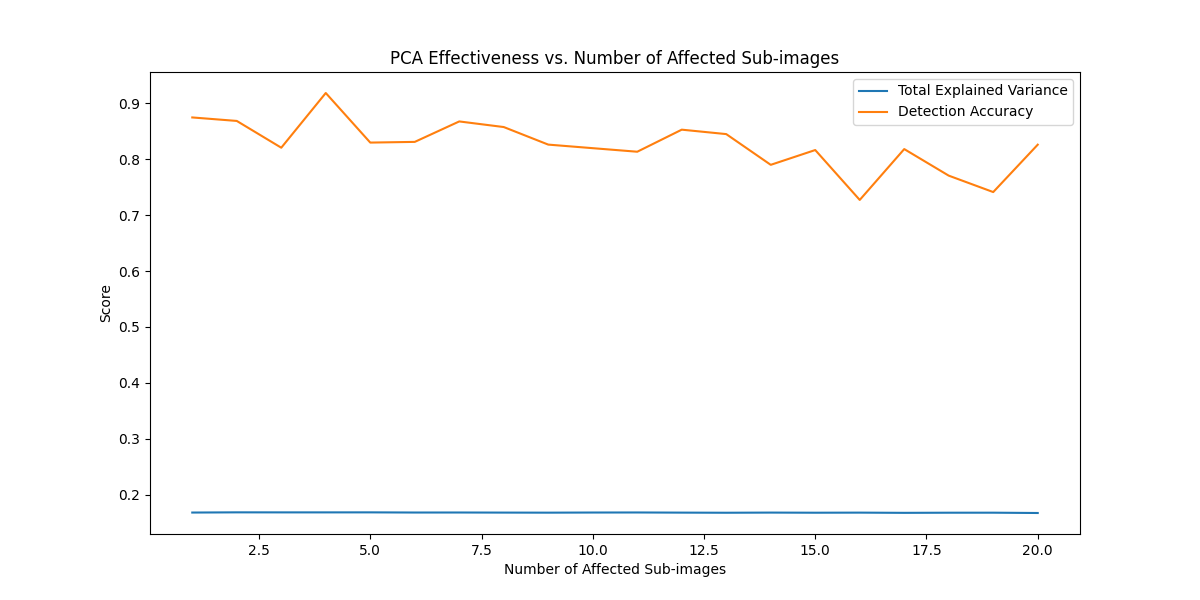

In [11]:
print(results)

n_affected = [r['n_affected_subimages'] for r in results]
explained_variance = [r['total_explained_variance'] for r in results]
detection_accuracy = [r['detection_accuracy'] for r in results]

plt.figure(figsize=(12, 6))
plt.plot(n_affected, explained_variance, label='Total Explained Variance')
plt.plot(n_affected, detection_accuracy, label='Detection Accuracy')
plt.xlabel('Number of Affected Sub-images')
plt.ylabel('Score')
plt.legend()
plt.title('PCA Effectiveness vs. Number of Affected Sub-images')
plt.show()